 Enhanced RL Allocator on cpu: 5 hidden layers, 128 nodes
 Network architecture: 16→128 → 128→128 → 128→128 → 128→64 → 64→64 → 64→64 → 64→300
 Max action size: 300

 Stage 1/5: size=(30, 50), K=[3, 4], p=[0.1, 0.15]
 Training for 1000 episodes | graph_range=(30, 50) | LR=0.0005
 Ep 20/1000 | Size 36 | Avoidable Decisions: 13.3 | Accuracy: 0.586 | Success: 0.965 | Loss: 0.36833 | Eps: 0.995 | LR: 5.00e-04
 Ep 40/1000 | Size 34 | Avoidable Decisions: 12.1 | Accuracy: 0.626 | Success: 0.942 | Loss: 0.35652 | Eps: 0.989 | LR: 5.00e-04
 Ep 60/1000 | Size 33 | Avoidable Decisions: 11.6 | Accuracy: 0.643 | Success: 0.935 | Loss: 0.33736 | Eps: 0.983 | LR: 5.00e-04
 Ep 80/1000 | Size 36 | Avoidable Decisions: 10.7 | Accuracy: 0.670 | Success: 0.926 | Loss: 0.31386 | Eps: 0.977 | LR: 5.00e-04
 LR updated to 5.00e-04 based on traditional success: 0.937
 Ep 100/1000 | Size 35 | Avoidable Decisions: 11.1 | Accuracy: 0.661 | Success: 0.931 | Loss: 0.28844 | Eps: 0.972 | LR: 5.00e-04
 Ep 120/1000 | 

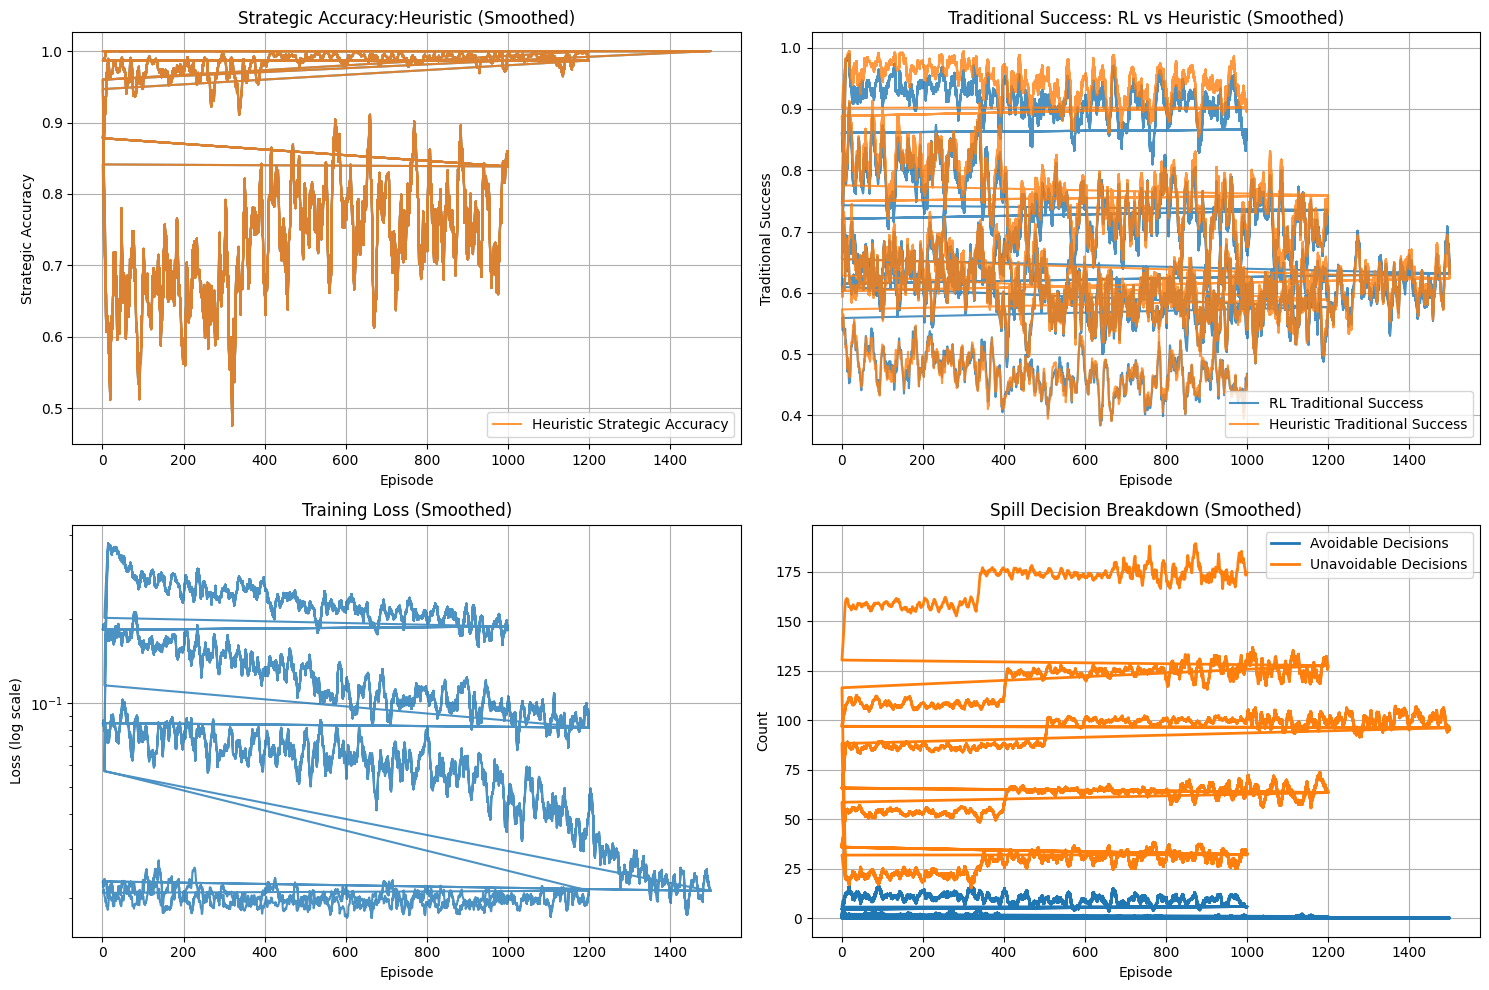

 Saved model to reg_alloc_corrected.pth
 All corrected training completed!


In [ ]:
# RL Model

import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from datetime import datetime

class RegAllocRL:

    def __init__(
        self,
        state_size=16,
        max_act_size=300,
        hidden_size=128,
        num_hidden=4,
        lr=1e-3,
        gamma=0.995,
        batch_size=64,
        mem_size=20000,
        eps_start=1.0,
        eps_min=0.05,
        eps_decay=0.999,
        target_update=50,
        device=None,
        use_double_dqn=True
    ):
        self.state_size = state_size
        self.max_act_size = max_act_size
        self.hidden_size = hidden_size
        self.num_hidden = num_hidden
        self.lr = lr
        self.gamma = gamma
        self.batch_size = batch_size
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.use_double_dqn = use_double_dqn

        self.model = self._build_model().to(self.device)
        self.target_model = self._build_model().to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        self.opt = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-5)
        self.criterion = nn.SmoothL1Loss()
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt, mode='max', factor=0.5, patience=50
        )

        self.memory = deque(maxlen=mem_size)
        self.train_steps = 0
        self.target_update = target_update

        self.epsilon = eps_start
        self.eps_min = eps_min
        self.eps_decay = eps_decay

        self.feat_cnt = 0
        self.feat_mean = np.zeros(self.state_size, dtype=np.float64)
        self.feat_var = np.ones(self.state_size, dtype=np.float64)

        self.hist = defaultdict(list)

        print(f" Enhanced RL Allocator on {self.device}: {num_hidden} hidden layers, {hidden_size} nodes")
        print(f" Network architecture: {self._get_arch()}")
        print(f" Max action size: {max_act_size}")



    def _build_model(self):
        layers = []

        layers.append(nn.Linear(self.state_size, self.hidden_size))
        layers.append(nn.BatchNorm1d(self.hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.2))

        curr_size = self.hidden_size

        for i in range(self.num_hidden):
            if i < self.num_hidden - 1:
                next_size = max(64, curr_size // (1 if i < 2 else 2))
            else:
                next_size = curr_size

            layers.append(nn.Linear(curr_size, next_size))
            layers.append(nn.BatchNorm1d(next_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1 + i * 0.05))

            curr_size = next_size

        layers.append(nn.Linear(curr_size, self.max_act_size))
        return nn.Sequential(*layers)



    def _get_arch(self):
        arch = []
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                arch.append(f"{layer.in_features}→{layer.out_features}")
        return " → ".join(arch)



    def _update_feat_stats(self, feats):
        x = np.asarray(feats, dtype=np.float64)
        if self.feat_cnt == 0:
            self.feat_mean[:] = x
            self.feat_var[:] = 1.0
            self.feat_cnt = 1
            return
        self.feat_cnt += 1
        old_mean = self.feat_mean.copy()
        self.feat_mean += (x - old_mean) / self.feat_cnt
        self.feat_var += (x - old_mean) * (x - self.feat_mean)



    def _normalize(self, feats):
        if self.feat_cnt < 2:
            return feats.astype(np.float32)
        mean = self.feat_mean
        var = np.maximum(self.feat_var / (self.feat_cnt - 1), 1e-6)
        return ((feats - mean) / np.sqrt(var)).astype(np.float32)



    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))



    def act(self, state, avail_actions, training=True):
        if training and np.random.random() <= self.epsilon:
            return random.choice(avail_actions)

        self.model.eval()
        with torch.no_grad():
            s = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_vals = self.model(s).cpu().numpy()[0]
        self.model.train()

        avail_q = [(a, q_vals[a]) for a in avail_actions if a < len(q_vals)]

        if not avail_q:
            return random.choice(avail_actions)

        best_act = max(avail_q, key=lambda x: x[1])[0]
        return best_act



    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0.0

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(np.array(actions)).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.BoolTensor(np.array(dones)).to(self.device)

        curr_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze()

        with torch.no_grad():
            if self.use_double_dqn:
                next_acts = torch.argmax(self.model(next_states), dim=1)
                next_q = self.target_model(next_states).gather(1, next_acts.unsqueeze(1)).squeeze()
            else:
                next_q = self.target_model(next_states).max(1)[0]

            target_q = rewards + (self.gamma * next_q * (~dones))

        loss = self.criterion(curr_q, target_q)

        self.opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.opt.step()

        self.train_steps += 1
        if self.train_steps % self.target_update == 0:
            self.target_model.load_state_dict(self.model.state_dict())

        if self.epsilon > self.eps_min:
            self.epsilon *= self.eps_decay

        return loss.item()



    def _gen_interf_graph(self, n, p=0.2, seed=None):
        if seed is not None:
            random.seed(seed)
        nodes = list(range(n))
        adj = {i: set() for i in nodes}
        for i in range(n):
            for j in range(i + 1, n):
                if random.random() < p:
                    adj[i].add(j)
                    adj[j].add(i)
        return adj



    def _gen_spill_costs(self, n):
        return {i: (15.0 if i % 5 == 0 else (8.0 if i % 3 == 0 else 1.0)) for i in range(n)}



    def _classify_spill(self, deg, K):
        if deg < K:
            return "avoidable"
        else:
            return "unavoidable"



    def _est_min_spills(self, adj, K):
        nodes = list(adj.keys())
        if not nodes:
            return 0

        max_deg = max(len(adj[n]) for n in nodes)
        min_spills = max(0, (max_deg + 1 - K)) // 2

        return min_spills



    def _extract_state(self, adj, costs, K, nodes, removed, alloc=None):
        rem_nodes = nodes - removed
        if not rem_nodes:
            return np.zeros(self.state_size, dtype=np.float32)

        degs = [len(adj[n]) for n in rem_nodes]
        cost_vals = [costs.get(n, 1.0) for n in rem_nodes]
        n_rem = len(rem_nodes)
        n_tot = len(nodes)

        max_deg = max(degs) if degs else 0
        min_spills = self._est_min_spills(adj, K)

        high_deg = len([d for d in degs if d >= K])
        low_deg = len([d for d in degs if d < K])

        spill_press = high_deg / max(1, low_deg)

        feats = [
            n_rem / n_tot,
            np.mean(degs) / (K + 1),
            max_deg / (K + 1),
            min(degs) / (K + 1) if degs else 0.0,
            np.std(degs) / (K + 1) if len(degs) > 1 else 0.0,
            np.mean(cost_vals) / 15.0,
            max(cost_vals) / 15.0 if cost_vals else 0.0,
            min(cost_vals) / 15.0 if cost_vals else 0.0,
            low_deg / max(1, n_rem),
            K / 10.0,
            np.median(degs) / (K + 1) if degs else 0.0,
            high_deg / max(1, n_rem),
            np.sum(degs) / (n_rem * max(1, K)),
            len(removed) / n_tot,
            min_spills / max(1, n_tot),
            spill_press
        ]

        return np.array(feats, dtype=np.float32)



    def _heuristic_solve(self, interf_adj, K, costs=None, spill_sel="cost_degree"):
        """MODIFIED: Added time measurement for heuristic evaluation"""
        start_time = time.time()

        if costs is None:
            costs = {n: 1.0 for n in interf_adj.keys()}

        adj = {n: set(neighs) for n, neighs in interf_adj.items()}
        nodes = set(adj.keys())
        stack = []
        removed = set()
        removal_dec = []  # track all removal

        def pick_spill():
            rem = nodes - removed
            if not rem:
                return None
            if spill_sel == "random":
                return random.choice(list(rem))
            elif spill_sel == "degree":
                return max(rem, key=lambda n: len(adj[n]))
            elif spill_sel == "high_cost":
                return max(rem, key=lambda n: costs.get(n, 1.0))
            elif spill_sel == "hybrid":
                return min(rem, key=lambda n: costs.get(n, 1.0) / (len(adj[n]) + 1))
            else:
                best = None
                best_met = float("inf")
                for n in rem:
                    d = len(adj[n])
                    met = costs.get(n, 1.0) / max(1, d)
                    if met < best_met:
                        best_met = met
                        best = n
                return best

        while len(removed) < len(nodes):
            low_deg = [n for n in nodes - removed if len(adj[n]) < K]
            if low_deg:
                for n in low_deg:
                    stack.append((n, False))
                    removed.add(n)

                    # track simplify decisions
                    deg = len(interf_adj[n])
                    cost = costs.get(n, 1.0)
                    dec_type = self._classify_spill(deg, K)
                    removal_dec.append((n, deg, dec_type, cost))

                    for m in list(adj[n]):
                        adj[m].discard(n)
                    adj[n].clear()
                continue

            n = pick_spill()
            if n is None:
                break
            stack.append((n, True))
            removed.add(n)

            #track spill decision
            deg = len(interf_adj[n])
            cost = costs.get(n, 1.0)
            dec_type = self._classify_spill(deg, K)
            removal_dec.append((n, deg, dec_type, cost))

            for m in list(adj[n]):
                adj[m].discard(n)
            adj[n].clear()

        alloc = {}
        spilled = set()
        orig_adj = {n: set(neighs) for n, neighs in interf_adj.items()}

        unavail_final = set()
        avail_final = set()

        while stack:
            n, _ = stack.pop()
            used = {alloc[neigh] for neigh in orig_adj.get(n, set()) if neigh in alloc}
            assign = next((c for c in range(K) if c not in used), None)
            if assign is None:
                spilled.add(n)
                deg = len(orig_adj[n])
                if deg < K:
                    avail_final.add(n)
                else:
                    unavail_final.add(n)
            else:
                alloc[n] = assign

        n_tot = len(nodes)
        # calculate strategic accuracy using all removal decisions
        tot_spill_dec = len(removal_dec)
        avail_dec = len([d for d in removal_dec if d[2] == "avoidable"])
        if tot_spill_dec > 0:
            strat_acc = 1.0 - (avail_dec / tot_spill_dec)
        else:
            strat_acc = 1.0

        # Calculate time taken
        heuristic_time = time.time() - start_time

        stats = {
            "nodes_tot": n_tot,
            "nodes_alloc": len(alloc),
            "nodes_spilled": len(spilled),
            "unavail_final": len(unavail_final),
            "avail_final": len(avail_final),
            "strat_acc": strat_acc,
            "trad_succ": (len(alloc) / n_tot) if n_tot > 0 else 0.0,
            "tot_spill_dec": tot_spill_dec,
            "avail_dec": avail_dec,
            "unavail_dec": len([d for d in removal_dec if d[2] == "unavoidable"]),
            "heuristic_time": heuristic_time  # Time measurement
        }
        return alloc, spilled, stats



    def _solve_rl(self, interf_adj, K, costs=None, training=True):
        """MODIFIED: Added time measurement for RL evaluation"""
        start_time = time.time()

        # save original graph for independent heuristic evaluation
        original_graph = {n: set(neighs) for n, neighs in interf_adj.items()}

        adj = {n: set(neighs) for n, neighs in interf_adj.items()}
        nodes = set(adj.keys())
        orig_adj = {n: set(neighs) for n, neighs in interf_adj.items()}

        if costs is None:
            costs = {n: 1.0 for n in nodes}

        stack = []
        removed = set()
        tot_rew = 0.0
        exp = []

        spill_dec = []

        while len(removed) < len(nodes):
            state_raw = self._extract_state(adj, costs, K, nodes, removed, {})
            if training:
                self._update_feat_stats(state_raw)
            state = self._normalize(state_raw)

            rem_nodes = list(nodes - removed)
            if len(rem_nodes) > self.max_act_size:
                rem_nodes = random.sample(rem_nodes, self.max_act_size)

            avail_acts = list(range(len(rem_nodes)))
            act_idx = self.act(state, avail_acts, training=training)
            chosen = rem_nodes[act_idx]

            stack.append((chosen, True))
            removed.add(chosen)

            deg = len(orig_adj[chosen])
            cost = costs.get(chosen, 1.0)
            dec_type = self._classify_spill(deg, K)
            spill_dec.append((chosen, deg, dec_type, cost))

            for m in list(adj[chosen]):
                if m in adj:
                    adj[m].discard(chosen)
            adj[chosen].clear()

            if deg < K:
                rew = -3.0 * (cost / 15.0)
            else:
                rew = -0.5 * (cost / 15.0)

            next_state_raw = self._extract_state(adj, costs, K, nodes, removed, {})
            if training:
                self._update_feat_stats(next_state_raw)
            next_state = self._normalize(next_state_raw)

            exp.append((state, act_idx, rew, next_state, False))
            tot_rew += rew

        alloc = {}
        spilled = set()
        unavail_final = set()
        avail_final = set()

        temp_stack = stack.copy()
        while temp_stack:
            n, _ = temp_stack.pop()
            used = {alloc.get(neigh) for neigh in orig_adj.get(n, set()) if neigh in alloc}
            assign = next((c for c in range(K) if c not in used), None)

            if assign is None:
                spilled.add(n)
                deg = len(orig_adj[n])
                if deg < K:
                    avail_final.add(n)
                else:
                    unavail_final.add(n)
            else:
                alloc[n] = assign

        for spill_node in spilled:
            cost_val = costs.get(spill_node, 1.0)
            if spill_node in avail_final:
                rew = -1.0 * (cost_val / 15.0)
            else:
                rew = -0.2 * (cost_val / 15.0)
            tot_rew += rew

        for n, _ in stack:
            if n in alloc and _:
                deg = len(orig_adj[n])
                cost_val = costs.get(n, 1.0)

                if deg >= K:
                    bonus = 2.0 + (cost_val / 20.0)
                else:
                    bonus = 0.5 + (cost_val / 20.0)

                tot_rew += bonus

        tot_spill_dec = len(spill_dec)
        avail_dec = len([d for d in spill_dec if d[2] == "avoidable"])

        if tot_spill_dec > 0:
            strat_acc = 1.0 - (avail_dec / tot_spill_dec)
        else:
            strat_acc = 1.0

        n_tot = len(nodes)
        trad_succ = len(alloc) / n_tot if n_tot > 0 else 0.0

        if strat_acc > 0.9:
            tot_rew += 3.0
        elif strat_acc > 0.8:
            tot_rew += 2.0
        elif strat_acc > 0.7:
            tot_rew += 1.0

        # Calculate RL time
        rl_time = time.time() - start_time

        stats = {
            "nodes_tot": len(nodes),
            "nodes_alloc": len(alloc),
            "nodes_spilled": len(spilled),
            "unavail_final": len(unavail_final),
            "avail_final": len(avail_final),
            "strat_acc": strat_acc,
            "trad_succ": trad_succ,
            "tot_rew": tot_rew,
            "tot_spill_dec": tot_spill_dec,
            "avail_dec": avail_dec,
            "unavail_dec": len([d for d in spill_dec if d[2] == "unavoidable"]),
            "rl_time": rl_time  # Time measurement
        }

        # Run heuristic on original unmodified graph for fair comparison
        _, _, heur_stats = self._heuristic_solve(original_graph, K, costs=costs, spill_sel="cost_degree")
        stats['heur_trad_succ'] = heur_stats.get('trad_succ', 0.0)
        stats['heur_strat_acc'] = heur_stats.get('strat_acc', 0.0)
        stats['heuristic_time'] = heur_stats.get('heuristic_time', 0.0)  # Heuristic time

        return alloc, spilled, stats, exp


    def train_problems(
        self,
        num_ep=500,
        graph_range=(30, 60),
        K_vals=[3, 4, 5],
        p_vals=[0.1, 0.15, 0.2],
        seed=None,
        verbose=True
    ):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)

        if verbose:
            print(f" Training for {num_ep} episodes | graph_range={graph_range} | LR={self.lr}")

        for ep in range(1, num_ep + 1):
            if ep < num_ep // 3:
                curr_range = (graph_range[0], graph_range[0] + (graph_range[1] - graph_range[0]) // 3)
            elif ep < 2 * num_ep // 3:
                curr_range = (graph_range[0] + (graph_range[1] - graph_range[0]) // 3,
                               graph_range[0] + 2 * (graph_range[1] - graph_range[0]) // 3)
            else:
                curr_range = graph_range

            graph_size = random.randint(curr_range[0], curr_range[1])
            K = random.choice(K_vals)
            p = random.choice(p_vals)

            graph = self._gen_interf_graph(graph_size, p, seed=ep)
            costs = self._gen_spill_costs(graph_size)

            alloc, spilled, stats, exp = self._solve_rl(graph, K, costs, training=True)

            for e in exp:
                self.remember(*e)

            loss = self.replay()

            self.hist['eps'].append(ep)
            self.hist['rews'].append(stats['tot_rew'])
            self.hist['spills'].append(stats['nodes_spilled'])
            self.hist['unavail_final'].append(stats['unavail_final'])
            self.hist['avail_final'].append(stats['avail_final'])
            self.hist['strat_acc'].append(stats['strat_acc'])
            self.hist['trad_succ'].append(stats['trad_succ'])
            self.hist['epsilon'].append(self.epsilon)
            self.hist['losses'].append(loss)
            self.hist['graph_sizes'].append(graph_size)
            self.hist['tot_spill_dec'].append(stats['tot_spill_dec'])
            self.hist['avail_dec'].append(stats['avail_dec'])
            self.hist['unavail_dec'].append(stats['unavail_dec'])

            self.hist['heur_strat_acc'].append(stats['heur_strat_acc'])
            self.hist['heur_trad_succ'].append(stats['heur_trad_succ'])

            if ep % 200 == 0:
                current_perf = self.evaluate(graph_size=80, num_tests=20, K=4, p=0.15)
                print(f" Interim Performance at episode {ep}: {current_perf}")

            # Using traditional success rate instead of strategic accuracy for LR scheduling
            if ep % 100 == 0 and self.hist['trad_succ']:
                recent_success = np.mean(self.hist['trad_succ'][-100:])
                self.scheduler.step(recent_success)
                if verbose:
                    curr_lr = self.opt.param_groups[0]['lr']
                    print(f" LR updated to {curr_lr:.2e} based on traditional success: {recent_success:.3f}")

            if verbose and ep % 20 == 0:
                recent_acc = np.mean(self.hist['strat_acc'][-50:]) if self.hist['strat_acc'] else 0.0
                recent_avail = np.mean(self.hist['avail_dec'][-50:]) if self.hist['avail_dec'] else 0.0
                recent_succ = np.mean(self.hist['trad_succ'][-50:]) if self.hist['trad_succ'] else 0.0
                recent_loss = np.mean([l for l in self.hist['losses'][-50:] if l > 0]) if self.hist['losses'] else 0.0
                curr_lr = self.opt.param_groups[0]['lr']
                print(f" Ep {ep}/{num_ep} | Size {graph_size} | Avoidable Decisions: {recent_avail:.1f} | Accuracy: {recent_acc:.3f} | Success: {recent_succ:.3f} | Loss: {recent_loss:.5f} | Eps: {self.epsilon:.3f} | LR: {curr_lr:.2e}")

        if verbose:
            print(" Training completed.")
        return self.hist



    def adv_curriculum(self):
        stages = [
            (1000, (30, 50), [3, 4], [0.1, 0.15]),
            (1200, (50, 80), [3, 4, 5], [0.15, 0.2]),
            (1500, (80, 120), [4, 5, 6], [0.2, 0.25]),
            (1200, (100, 150), [5, 6, 7], [0.2, 0.3]),
            (1000, (150, 200), [6, 7, 8], [0.25, 0.35])
        ]

        tot_hist = defaultdict(list)

        for i, (eps, size_range, K_vals, p_vals) in enumerate(stages):
            print(f"\n Stage {i+1}/{len(stages)}: size={size_range}, K={K_vals}, p={p_vals}")

            if i > 0:
                for param_group in self.opt.param_groups:
                    param_group['lr'] *= 0.8
                print(f" Adjusted learning rate to {self.opt.param_groups[0]['lr']:.2e}")

            hist = self.train_problems(
                num_ep=eps,
                graph_range=size_range,
                K_vals=K_vals,
                p_vals=p_vals,
                verbose=True
            )

            for k, v in hist.items():
                tot_hist[k].extend(v)

            self.save(f"reg_alloc_stage_{i+1}.pth")

        return tot_hist



    def evaluate(self, graph_size=100, num_tests=100, K=4, p=0.15):
        """MODIFIED: Print time measurements along with accuracy metrics"""
        print(f" Evaluating on {num_tests} problems (size={graph_size}, K={K}, p={p})")
        strat_accs = []
        trad_succs = []
        heur_strat_accs = []
        heur_trad_succs = []
        rl_times = []      # Collect RL times
        heur_times = []    # Collect heuristic times

        for t in range(num_tests):
            graph = self._gen_interf_graph(graph_size, p, seed=1000 + t)
            costs = self._gen_spill_costs(graph_size)

            alloc, spilled, stats, _ = self._solve_rl(graph, K, costs, training=False)
            strat_accs.append(stats['strat_acc'])
            trad_succs.append(stats['trad_succ'])
            heur_strat_accs.append(stats['heur_strat_acc'])
            heur_trad_succs.append(stats['heur_trad_succ'])
            rl_times.append(stats['rl_time'])
            heur_times.append(stats['heuristic_time'])

        avg_strat_acc = float(np.mean(strat_accs))
        avg_trad_succ = float(np.mean(trad_succs))
        avg_heur_strat_acc = float(np.mean(heur_strat_accs))
        avg_heur_trad_succ = float(np.mean(heur_trad_succs))
        avg_rl_time = float(np.mean(rl_times))
        avg_heur_time = float(np.mean(heur_times))

        print(f"   RL Performance:")
        print(f"   Strategic Accuracy: {avg_strat_acc:.3f}")
        print(f"   Traditional Success: {avg_trad_succ:.3f}")
        print(f"   Average Evaluation Time: {avg_rl_time:.4f}s")

        print(f"   Heuristic Baseline (cost_degree):")
        print(f"   Strategic Accuracy: {avg_heur_strat_acc:.3f}")
        print(f"   Traditional Success: {avg_heur_trad_succ:.3f}")
        print(f"   Average Evaluation Time: {avg_heur_time:.4f}s")

        acc_imp = avg_strat_acc - avg_heur_strat_acc
        succ_imp = avg_trad_succ - avg_heur_trad_succ
        time_ratio = avg_rl_time / avg_heur_time if avg_heur_time > 0 else float('inf')

        print(f"  Improvement over Heuristic:")
        print(f"  Strategic Accuracy: {acc_imp:+.3f}")
        print(f"  Traditional Success: {succ_imp:+.3f}")
        print(f"  Time Ratio (RL/Heuristic): {time_ratio:.2f}x")

        return (avg_strat_acc, avg_trad_succ,
                avg_heur_strat_acc, avg_heur_trad_succ,
                avg_rl_time, avg_heur_time)  # Return times


    def model_evaluation(self, num_tests=50, test_cases = [
            (100, 4, 0.15),
            (200, 4, 0.1),
            (150, 6, 0.2),
            (80, 3, 0.25),
            (250, 4, 0.08),
        ]):
        """Include time measurements in final evaluation table"""
        test_cases = test_cases

        res = {}
        for size, K, p in test_cases:
            print(f" Testing: size={size}, K={K}, p={p}")
            # Unpack time values
            rl_acc, rl_succ, heur_acc, heur_succ, rl_time, heur_time = self.evaluate(
                size, num_tests//len(test_cases), K, p
            )
            res[(size, K, p)] = (rl_acc, rl_succ, heur_acc, heur_succ, rl_time, heur_time)

        print("\n FINAL CORRECTED STRATEGIC EVALUATION WITH TIMING (TABULAR):")
        # Updated header to include time columns
        header = f"{'Size':>6} | {'K':>2} | {'p':>5} | {'RL Acc':>7} | {'RL Succ':>8} | {'Heur Acc':>9} | {'Heur Succ':>10} | {'RL Time':>8} | {'Heur Time':>10} | {'Time Ratio':>11}"
        print(header)
        print('-' * len(header))
        for (size, K, p), (rl_acc, rl_succ, heur_acc, heur_succ, rl_time, heur_time) in res.items():
            time_ratio = rl_time / heur_time if heur_time > 0 else float('inf')
            # Print time values
            print(f"{size:6d} | {K:2d} | {p:5.2f} | {rl_acc:7.3f} | {rl_succ:8.3f} | {heur_acc:9.3f} | {heur_succ:10.3f} | {rl_time:8.4f}s | {heur_time:10.4f}s | {time_ratio:11.2f}x")

        return res



    def _mov_avg(self, data, window=10):
        if len(data) == 0:
            return data
        window = max(1, min(window, len(data)))
        return np.convolve(data, np.ones(window)/window, mode='valid')



    def plot_progress(self, hist=None):
        if hist is None:
            hist = self.hist

        if not hist['eps']:
            print("No training data to plot")
            return

        window = 10

        eps = np.array(hist['eps'])

        sa_rl = np.array(hist['strat_acc']) if 'strat_acc' in hist else np.array([])
        sa_heu = np.array(hist['heur_strat_acc']) if 'heur_strat_acc' in hist else np.array([])
        sa_rl_smooth = self._mov_avg(sa_rl, window)
        sa_heu_smooth = self._mov_avg(sa_heu, window)
        ep_sa = eps[window-1:len(sa_rl_smooth)+window-1]

        ts_rl = np.array(hist['trad_succ']) if 'trad_succ' in hist else np.array([])
        ts_heu = np.array(hist['heur_trad_succ']) if 'heur_trad_succ' in hist else np.array([])
        ts_rl_smooth = self._mov_avg(ts_rl, window)
        ts_heu_smooth = self._mov_avg(ts_heu, window)
        ep_ts = eps[window-1:len(ts_rl_smooth)+window-1]

        losses = [l for l in hist['losses'] if l > 0]
        ep_loss = [hist['eps'][i] for i, l in enumerate(hist['losses']) if l > 0]
        loss_smooth = self._mov_avg(np.array(losses), window) if losses else []
        ep_loss_smooth = np.array(ep_loss)[window-1:len(loss_smooth)+window-1] if len(loss_smooth) > 0 else []

        avoid = np.array(hist['avail_dec']) if 'avail_dec' in hist else np.array([])
        unavoid = np.array(hist['unavail_dec']) if 'unavail_dec' in hist else np.array([])
        avoid_smooth = self._mov_avg(avoid, window)
        unavoid_smooth = self._mov_avg(unavoid, window)
        ep_dec = eps[window-1:len(avoid_smooth)+window-1]

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        if len(sa_rl_smooth) > 0 and len(sa_heu_smooth) > 0:
            ax1.plot(ep_sa, sa_rl_smooth, alpha=0.8)
            ax1.plot(ep_sa, sa_heu_smooth, alpha=0.8, label='Heuristic Strategic Accuracy')
        else:
            ax1.plot(eps, sa_rl, alpha=0.8)
            if len(sa_heu) > 0:
                ax1.plot(eps, sa_heu, alpha=0.8, label='Heuristic Strategic Accuracy')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Strategic Accuracy')
        ax1.set_title('Strategic Accuracy:Heuristic (Smoothed)')
        ax1.legend()
        ax1.grid(True)

        if len(ts_rl_smooth) > 0 and len(ts_heu_smooth) > 0:
            ax2.plot(ep_ts, ts_rl_smooth, alpha=0.8, label='RL Traditional Success')
            ax2.plot(ep_ts, ts_heu_smooth, alpha=0.8, label='Heuristic Traditional Success')
        else:
            ax2.plot(eps, ts_rl, alpha=0.8, label='RL Traditional Success')
            if len(ts_heu) > 0:
                ax2.plot(eps, ts_heu, alpha=0.8, label='Heuristic Traditional Success')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Traditional Success')
        ax2.set_title('Traditional Success: RL vs Heuristic (Smoothed)')
        ax2.legend()
        ax2.grid(True)

        if len(loss_smooth) > 0:
            ax3.semilogy(ep_loss_smooth, loss_smooth, alpha=0.8)
            ax3.set_xlabel('Episode')
            ax3.set_ylabel('Loss (log scale)')
            ax3.set_title('Training Loss (Smoothed)')
            ax3.grid(True)
        else:
            ax3.text(0.5, 0.5, 'No loss data', horizontalalignment='center', verticalalignment='center')
            ax3.set_axis_off()

        if len(avoid_smooth) > 0 and len(unavoid_smooth) > 0:
            ax4.plot(ep_dec, avoid_smooth, label='Avoidable Decisions', linewidth=2)
            ax4.plot(ep_dec, unavoid_smooth, label='Unavoidable Decisions', linewidth=2)
        else:
            ax4.plot(eps, avoid, label='Avoidable Decisions', alpha=0.8)
            ax4.plot(eps, unavoid, label='Unavoidable Decisions', alpha=0.8)
        ax4.set_xlabel('Episode')
        ax4.set_ylabel('Count')
        ax4.set_title('Spill Decision Breakdown (Smoothed)')
        ax4.legend()
        ax4.grid(True)

        plt.tight_layout()
        plt.show()



    def save(self, path):
        torch.save({
            'model_state': self.model.state_dict(),
            'target_state': self.target_model.state_dict(),
            'opt_state': self.opt.state_dict(),
            'scheduler_state': self.scheduler.state_dict(),
            'epsilon': self.epsilon,
            'feat_cnt': self.feat_cnt,
            'feat_mean': self.feat_mean,
            'feat_var': self.feat_var,
            'hist': dict(self.hist)
        }, path)
        print(f" Saved model to {path}")



    def load(self, path):
        data = torch.load(path, map_location=self.device)
        self.model.load_state_dict(data['model_state'])
        self.target_model.load_state_dict(data.get('target_state', data['model_state']))
        self.opt.load_state_dict(data.get('opt_state', self.opt.state_dict()))
        if 'scheduler_state' in data:
            self.scheduler.load_state_dict(data['scheduler_state'])
        self.epsilon = data.get('epsilon', self.epsilon)
        self.feat_cnt = data.get('feat_cnt', self.feat_cnt)
        self.feat_mean = data.get('feat_mean', self.feat_mean)
        self.feat_var = data.get('feat_var', self.feat_var)
        if 'hist' in data:
            self.hist.update(data['hist'])
        print(f" Loaded model from {path}")




if __name__ == "__main__":
    agent = RegAllocRL(
        state_size=16,
        max_act_size=300,
        hidden_size=128,
        num_hidden=5,
        lr=5e-4,
        batch_size=128,
        target_update=200,
        eps_decay=0.9997,
        eps_min=0.01,
        use_double_dqn=True,
        mem_size=200000
    )

    tot_hist = agent.adv_curriculum()

    print("\n Final CORRECTED STRATEGIC EVALUATION... (table below)")
    eval_res = agent.model_evaluation(num_tests=50)

    agent.plot_progress(tot_hist)

    agent.save("reg_alloc_corrected.pth")

    print(" All corrected training completed!")

In [ ]:
 # Agent Evaluation

agent.model_evaluation(num_tests=10,test_cases = [(50,4,0.3)])

 Testing: size=50, K=4, p=0.3
 Evaluating on 10 problems (size=50, K=4, p=0.3)
   RL Performance:
   Strategic Accuracy: 1.000
   Traditional Success: 0.620
   Average Evaluation Time: 0.0839s
   Heuristic Baseline (cost_degree):
   Strategic Accuracy: 1.000
   Traditional Success: 0.624
   Average Evaluation Time: 0.0014s
  Improvement over Heuristic:
  Strategic Accuracy: +0.000
  Traditional Success: -0.004
  Time Ratio (RL/Heuristic): 61.74x

 FINAL CORRECTED STRATEGIC EVALUATION WITH TIMING (TABULAR):
  Size |  K |     p |  RL Acc |  RL Succ |  Heur Acc |  Heur Succ |  RL Time |  Heur Time |  Time Ratio
-------------------------------------------------------------------------------------------------------
    50 |  4 |  0.30 |   1.000 |    0.620 |     1.000 |      0.624 |   0.0839s |     0.0014s |       61.74x


{(50, 4, 0.3): (1.0,
  0.6199999999999999,
  1.0,
  0.6240000000000001,
  0.08391492366790772,
  0.0013590574264526368)}

In [ ]:
# GUI Implementation

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import matplotlib.patches as mpatches
import torch
import time
from datetime import datetime
import json
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter, PillowWriter
import tempfile
import os

class RegAllocGUI:
    def __init__(self, agent=None):
        self.current_graph = None
        self.current_costs = None
        self.agent = agent
        self.performance_history = []
        self.comparison_history = []
        self.animation_steps = []
        self.current_step = 0

        self.colors = {
            'primary': '#00ff9f',
            'secondary': '#00b8ff',
            'accent': '#ff00aa',
            'warning': '#ffd300',
            'danger': '#ff003c',
            'success': '#00ff9f',
            'info': '#00b8ff',
            'dark_bg': '#0a0a12',
            'darker_bg': '#050508',
            'card_bg': '#151520',
            'border': '#2a2a3a',
            'text_primary': '#ffffff',
            'text_secondary': '#b8b8cc',
            'neon_purple': '#bd00ff',
            'neon_blue': '#0080ff',
            'neon_green': '#00ff9f',
            'neon_pink': '#ff00aa',
            'neon_yellow': '#ffd300'
        }

        # Animation states
        self.animation_running = False
        self.current_step = 0

        # Setup GUI
        self.setup_gui()
        self.update_model_status()

    def setup_gui(self):
        self.tab = widgets.Tab(layout=widgets.Layout(
            width='100%',
            margin='0px',
            padding='0px'
        ))

        # Create enhanced tabs
        self.eval_tab = self.create_evaluation_tab()
        self.manual_tab = self.create_manual_tab()
        self.results_tab = self.create_results_tab()
        self.analytics_tab = self.create_analytics_tab()

        self.tab.children = [self.eval_tab, self.manual_tab, self.results_tab, self.analytics_tab]
        self.tab.titles = ['🧪 EVAL', '✏️ MANUAL', '📊 RESULTS', '📈 ANALYTICS']

        # Enhanced output areas
        self.console_output = widgets.Output(layout=widgets.Layout(
            height='180px',
            overflow_y='auto',
            border=f'1px solid {self.colors["border"]}',
            border_radius='8px',
            padding='15px',
            background_color=self.colors['darker_bg']
        ))

        self.graph_output = widgets.Output(layout=widgets.Layout(
            height='520px',
            border=f'1px solid {self.colors["border"]}',
            border_radius='8px',
            padding='15px',
            background_color=self.colors['dark_bg']
        ))

        # Real-time stats panel
        self.stats_panel = self.create_stats_panel()

        main_layout = widgets.VBox([
            widgets.HTML(f"""
                <div style='
                    text-align: center;
                    padding: 20px;
                    background: linear-gradient(135deg, {self.colors['darker_bg']} 0%, {self.colors['dark_bg']} 100%);
                    color: {self.colors['text_primary']};
                    border-radius: 12px;
                    border: 1px solid {self.colors['border']};
                    margin-bottom: 20px;
                    box-shadow: 0 0 20px {self.colors['primary']}33;
                    position: relative;
                    overflow: hidden;
                '>
                    <div style='position: absolute; top: 0; left: 0; right: 0; height: 2px; background: linear-gradient(90deg, {self.colors['primary']}, {self.colors['accent']});'></div>
                    <h1 style='margin: 0; font-size: 28px; font-weight: 800; background: linear-gradient(45deg, {self.colors['primary']}, {self.colors['secondary']}); -webkit-background-clip: text; -webkit-text-fill-color: transparent; text-shadow: 0 0 30px {self.colors['primary']}80;'>
                        🚀 REGISTER ALLOCATION VISUALIZER
                    </h1>
                    <p style='margin: 8px 0 0 0; opacity: 0.8; font-size: 14px; font-family: "Courier New", monospace;'>
                        NEURAL NETWORK OPTIMIZATION ENGINE • REAL-TIME ANALYSIS
                    </p>
                </div>
            """),

            widgets.HBox([
                # Left panel with tabs and stats
                widgets.VBox([
                    self.tab,
                    self.stats_panel
                ], layout=widgets.Layout(width='55%', margin='0px 10px 0px 0px')),

                # Right panel with visualization
                widgets.VBox([
                    widgets.HTML(f"""
                        <div style='
                            background: {self.colors['card_bg']};
                            padding: 15px;
                            border-radius: 10px;
                            border: 1px solid {self.colors['border']};
                            margin-bottom: 10px;
                            box-shadow: 0 0 15px {self.colors['primary']}20;
                        '>
                            <h3 style='margin: 0 0 8px 0; color: {self.colors['text_primary']}; font-size: 16px;'>
                                🎯 GRAPH VISUALIZATION
                            </h3>
                            <p style='margin: 0; color: {self.colors['text_secondary']}; font-size: 12px; font-family: "Courier New", monospace;'>
                                REAL-TIME ALLOCATION ANALYSIS
                            </p>
                        </div>
                    """),
                    self.graph_output
                ], layout=widgets.Layout(width='45%'))
            ], layout=widgets.Layout(margin='0px 0px 20px 0px')),

            # Console output header
            widgets.HTML(f"""
                <div style='
                    background: {self.colors['card_bg']};
                    padding: 12px 15px;
                    border-radius: 8px;
                    border: 1px solid {self.colors['border']};
                    margin-bottom: 8px;
                    box-shadow: 0 0 10px {self.colors['primary']}15;
                '>
                    <h3 style='margin: 0; color: {self.colors['text_primary']}; font-size: 14px; font-family: "Courier New", monospace;'>
                        ⚡ SYSTEM CONSOLE
                    </h3>
                </div>
            """),
            self.console_output
        ], layout=widgets.Layout(
            padding='25px',
            background_color=self.colors['darker_bg']
        ))

        display(main_layout)

    def create_evaluation_tab(self):
        header = widgets.HTML(f"""
            <div style='
                background: linear-gradient(135deg, {self.colors['card_bg']} 0%, {self.colors['dark_bg']} 100%);
                color: {self.colors['text_primary']};
                padding: 20px;
                border-radius: 10px;
                border: 1px solid {self.colors['border']};
                margin-bottom: 20px;
                box-shadow: 0 0 20px {self.colors['primary']}25;
                position: relative;
                overflow: hidden;
            '>
                <div style='position: absolute; top: 0; left: 0; right: 0; height: 3px; background: linear-gradient(90deg, {self.colors['primary']}, {self.colors['accent']});'></div>
                <h3 style='margin: 0 0 8px 0; font-size: 18px; color: {self.colors['primary']};'>🧪 INTERACTIVE EVALUATION</h3>
                <p style='margin: 0; color: {self.colors['text_secondary']}; font-size: 13px; font-family: "Courier New", monospace;'>
                    GENERATE RANDOM GRAPHS • EVALUATE RL MODEL • COMPARE PERFORMANCE
                </p>
            </div>
        """)

        self.model_status_display = widgets.HTML(
            value=f"""
            <div style='
                background: {self.colors['card_bg']};
                padding: 15px;
                border-radius: 8px;
                border: 1px solid {self.colors['border']};
                margin-bottom: 20px;
                box-shadow: 0 0 15px {self.colors['primary']}20;
            '>
                <div style='display: flex; align-items: center; gap: 12px;'>
                    <span style='font-size: 20px;'>🔮</span>
                    <div>
                        <b style='color: {self.colors['text_primary']};'>MODEL STATUS:</b>
                        <span style='color: {self.colors['warning']}; font-family: "Courier New", monospace;'>INITIALIZING...</span>
                    </div>
                </div>
            </div>
            """
        )

        # Enhanced configuration section
        config_header = widgets.HTML(f"""
            <div style='
                padding: 12px 0;
                border-bottom: 2px solid {self.colors['border']};
                margin-bottom: 15px;
            '>
                <h4 style='margin: 0; color: {self.colors['primary']}; font-size: 14px; font-family: "Courier New", monospace;'>
                    ⚙️ GRAPH CONFIGURATION
                </h4>
            </div>
        """)

        slider_style = {'description_width': '140px', 'font_size': '12px'}
        slider_layout = widgets.Layout(width='96%', margin='8px 0px')

        self.node_count = widgets.IntSlider(
            value=50, min=10, max=500, description='🖥️  NODES:',
            style=slider_style, layout=slider_layout,
            continuous_update=False
        )

        self.k_value = widgets.IntSlider(
            value=4, min=2, max=20, description='🎯  REGISTERS (K):',
            style=slider_style, layout=slider_layout,
            continuous_update=False
        )

        self.edge_prob = widgets.FloatSlider(
            value=0.3, min=0.05, max=1.0, step=0.05, description='🔗  EDGE PROBABILITY:',
            style=slider_style, layout=slider_layout,
            continuous_update=False
        )

        # Complexity indicator
        self.complexity_indicator = widgets.HTML("""
            <div style='text-align: center; padding: 8px; background: #151520; border-radius: 6px; border: 1px solid #2a2a3a;'>
                <span style='color: #00ff9f; font-family: "Courier New", monospace; font-size: 11px;'>COMPLEXITY: MEDIUM</span>
            </div>
        """)

        button_layout = widgets.Layout(width='auto', margin='6px', height='40px', min_width='120px')

        self.generate_btn = widgets.Button(
            description='🎲 GENERATE GRAPH',
            button_style='primary',
            layout=button_layout,
            style={'font_weight': 'bold', 'font_size': '12px'}
        )

        self.evaluate_btn = widgets.Button(
            description='🚀 EVALUATE MODEL',
            button_style='success',
            layout=button_layout,
            style={'font_weight': 'bold', 'font_size': '12px'}
        )

        self.compare_btn = widgets.Button(
            description='⚖️ COMPARE METHODS',
            button_style='info',
            layout=button_layout,
            style={'font_weight': 'bold', 'font_size': '12px'}
        )

        self.animate_btn = widgets.Button(
           description='🎬 RENDER ALLOCATION VIDEO',
           button_style='warning',
           layout=button_layout,
           style={'font_weight': 'bold', 'font_size': '12px'}
       )

        # Connect buttons to functions
        self.generate_btn.on_click(lambda x: self.generate_random_graph())
        self.evaluate_btn.on_click(lambda x: self.evaluate_model())
        self.compare_btn.on_click(lambda x: self.compare_with_heuristic())
        self.animate_btn.on_click(lambda x: self.toggle_animation())

        # Main button container
        main_button_container = widgets.GridBox(
            [self.generate_btn, self.evaluate_btn, self.compare_btn, self.animate_btn],
            layout=widgets.Layout(
                grid_template_columns='repeat(2, 1fr)',
                gap='10px',
                margin='20px 0px 0px 0px'
            )
        )

        # Return the complete tab content
        return widgets.VBox([
            header,
            self.model_status_display,
            config_header,
            self.node_count,
            self.k_value,
            self.edge_prob,
            self.complexity_indicator,
            main_button_container,
            self.create_graph_info_display()
        ], layout=widgets.Layout(
            padding='20px',
            background_color=self.colors['card_bg'],
            border_radius='10px',
            border=f'1px solid {self.colors["border"]}',
            margin='5px'
        ))

    def create_manual_tab(self):
        header = widgets.HTML(f"""
            <div style='
                background: linear-gradient(135deg, {self.colors['card_bg']} 0%, {self.colors['dark_bg']} 100%);
                color: {self.colors['text_primary']};
                padding: 20px;
                border-radius: 10px;
                border: 1px solid {self.colors['border']};
                margin-bottom: 20px;
                box-shadow: 0 0 20px {self.colors['secondary']}25;
            '>
                <h3 style='margin: 0 0 8px 0; font-size: 18px; color: {self.colors['secondary']};'>✏️ MANUAL GRAPH INPUT</h3>
                <p style='margin: 0; color: {self.colors['text_secondary']}; font-size: 13px; font-family: "Courier New", monospace;'>
                    CUSTOM GRAPHS • ADVANCED CONFIGURATION • FINE-TUNED ANALYSIS
                </p>
            </div>
        """)

        self.adj_text = widgets.Textarea(
            value='',
            placeholder='Enter adjacency list:\n0: 1, 2\n1: 0, 3\n2: 0\n3: 1',
            description='📝 GRAPH INPUT:',
            layout=widgets.Layout(width='100%', height='180px'),
            style={
                'description_width': 'initial',
                'background': self.colors['dark_bg'],
                'color': self.colors['text_primary'],
                'border': f'1px solid {self.colors["border"]}'
            }
        )

        # Enhanced buttons for manual tab
        button_layout = widgets.Layout(width='auto', margin='8px', height='36px')

        self.load_example_btn = widgets.Button(
            description='📋 LOAD EXAMPLE',
            button_style='warning',
            layout=button_layout,
            style={'font_weight': 'bold'}
        )

        self.evaluate_custom_btn = widgets.Button(
            description='🔍 EVALUATE CUSTOM',
            button_style='success',
            layout=button_layout,
            style={'font_weight': 'bold'}
        )

        self.analyze_btn = widgets.Button(
            description='📈 ADVANCED ANALYSIS',
            button_style='info',
            layout=button_layout,
            style={'font_weight': 'bold'}
        )

        # Connect buttons
        self.load_example_btn.on_click(lambda x: self.load_example())
        self.evaluate_custom_btn.on_click(lambda x: self.evaluate_custom_graph())
        self.analyze_btn.on_click(lambda x: self.advanced_analysis())

        return widgets.VBox([
            header,
            self.adj_text,
            widgets.HBox([self.load_example_btn, self.evaluate_custom_btn, self.analyze_btn])
        ], layout=widgets.Layout(
            padding='20px',
            background_color=self.colors['card_bg'],
            border_radius='10px',
            border=f'1px solid {self.colors["border"]}',
            margin='5px'
        ))

    def create_results_tab(self):
        header = widgets.HTML(f"""
            <div style='
                background: linear-gradient(135deg, {self.colors['card_bg']} 0%, {self.colors['dark_bg']} 100%);
                color: {self.colors['text_primary']};
                padding: 20px;
                border-radius: 10px;
                border: 1px solid {self.colors['border']};
                margin-bottom: 20px;
                box-shadow: 0 0 20px {self.colors['accent']}25;
            '>
                <h3 style='margin: 0 0 8px 0; font-size: 18px; color: {self.colors['accent']};'>📊 RESULTS DASHBOARD</h3>
                <p style='margin: 0; color: {self.colors['text_secondary']}; font-size: 13px; font-family: "Courier New", monospace;'>
                    PERFORMANCE METRICS • COMPARISON ANALYSIS • HISTORICAL DATA
                </p>
            </div>
        """)

        self.results_display = widgets.HTML(
            value=f"""
            <div style='
                text-align: center;
                padding: 60px 20px;
                color: {self.colors['text_secondary']};
                background: {self.colors['card_bg']};
                border-radius: 10px;
                border: 2px dashed {self.colors['border']};
                font-family: "Courier New", monospace;
            '>
                <div style='font-size: 48px; margin-bottom: 20px; opacity: 0.5;'>⚡</div>
                <h3 style='margin: 0 0 10px 0; color: {self.colors['text_secondary']}; opacity: 0.7;'>SYSTEM READY</h3>
                <p style='margin: 0; font-size: 14px;'>AWAITING ANALYSIS COMMANDS</p>
            </div>
            """,
            layout=widgets.Layout(height='400px', overflow='auto', padding='10px')
        )

        return widgets.VBox([
            header,
            self.results_display
        ], layout=widgets.Layout(
            padding='20px',
            background_color=self.colors['card_bg'],
            border_radius='10px',
            border=f'1px solid {self.colors["border"]}',
            margin='5px'
        ))

    def create_analytics_tab(self):
        """UPDATED: Enhanced analytics tab with time performance analysis"""
        header = widgets.HTML(f"""
            <div style='
                background: linear-gradient(135deg, {self.colors['card_bg']} 0%, {self.colors['dark_bg']} 100%);
                color: {self.colors['text_primary']};
                padding: 20px;
                border-radius: 10px;
                border: 1px solid {self.colors['border']};
                margin-bottom: 20px;
                box-shadow: 0 0 20px {self.colors['neon_purple']}25;
            '>
                <h3 style='margin: 0 0 8px 0; font-size: 18px; color: {self.colors['neon_purple']};'>📈 PERFORMANCE ANALYTICS</h3>
                <p style='margin: 0; color: {self.colors['text_secondary']}; font-size: 13px; font-family: "Courier New", monospace;'>
                    HISTORICAL DATA • TREND ANALYSIS • TIME PERFORMANCE • PERFORMANCE INSIGHTS
                </p>
            </div>
        """)

        # Analytics controls
        self.analytics_time_range = widgets.Dropdown(
            options=['Last 10', 'Last 25', 'Last 50', 'All Time'],
            value='Last 25',
            description='📊 Time Range:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='200px')
        )

        # "Time Performance" option
        self.analytics_metric = widgets.Dropdown(
            options=['Success Rate', 'Strategic Accuracy', 'Improvement vs Heuristic', 'Time Performance'],
            value='Success Rate',
            description='📈 Metric:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='220px')
        )

        self.refresh_analytics_btn = widgets.Button(
            description='🔄 Refresh Analytics',
            button_style='info',
            layout=widgets.Layout(width='180px', height='36px')
        )

        self.clear_analytics_btn = widgets.Button(
            description='🗑️ Clear History',
            button_style='warning',
            layout=widgets.Layout(width='150px', height='36px')
        )

        self.export_analytics_btn = widgets.Button(
            description='💾 Export Data',
            button_style='success',
            layout=widgets.Layout(width='140px', height='36px')
        )

        # Connect buttons
        self.refresh_analytics_btn.on_click(lambda x: self.update_analytics_display())
        self.clear_analytics_btn.on_click(lambda x: self.clear_analytics_data())
        self.export_analytics_btn.on_click(lambda x: self.export_analytics_data())
        self.analytics_time_range.observe(lambda x: self.update_analytics_display(), 'value')
        self.analytics_metric.observe(lambda x: self.update_analytics_display(), 'value')

        # Analytics display
        self.analytics_display = widgets.HTML(
            value=self._get_analytics_placeholder(),
            layout=widgets.Layout(height='500px', overflow='auto', padding='10px')
        )

        controls = widgets.HBox([
            self.analytics_time_range,
            self.analytics_metric,
            self.refresh_analytics_btn,
            self.clear_analytics_btn,
            self.export_analytics_btn
        ], layout=widgets.Layout(
            justify_content='space-between',
            margin='0px 0px 15px 0px'
        ))

        return widgets.VBox([
            header,
            controls,
            self.analytics_display
        ], layout=widgets.Layout(
            padding='20px',
            background_color=self.colors['card_bg'],
            border_radius='10px',
            border=f'1px solid {self.colors["border"]}',
            margin='5px'
        ))

    def create_stats_panel(self):
        """Real-time statistics panel"""
        self.stats_display = widgets.HTML(f"""
            <div style='
                background: {self.colors['card_bg']};
                padding: 20px;
                border-radius: 10px;
                border: 1px solid {self.colors['border']};
                margin-top: 10px;
                box-shadow: 0 0 15px {self.colors['primary']}20;
            '>
                <h4 style='margin: 0 0 15px 0; color: {self.colors['primary']}; font-size: 14px; font-family: "Courier New", monospace;'>
                    📈 REAL-TIME STATS
                </h4>

                <div style='display: grid; grid-template-columns: 1fr 1fr; gap: 12px;'>
                    <div style='background: {self.colors['dark_bg']}; padding: 10px; border-radius: 6px; border-left: 3px solid {self.colors['success']};'>
                        <div style='color: {self.colors['text_secondary']}; font-size: 11px;'>SUCCESS RATE</div>
                        <div style='color: {self.colors['success']}; font-size: 16px; font-weight: bold;'>--</div>
                    </div>

                    <div style='background: {self.colors['dark_bg']}; padding: 10px; border-radius: 6px; border-left: 3px solid {self.colors['info']};'>
                        <div style='color: {self.colors['text_secondary']}; font-size: 11px;'>ACCURACY</div>
                        <div style='color: {self.colors['info']}; font-size: 16px; font-weight: bold;'>--</div>
                    </div>

                    <div style='background: {self.colors['dark_bg']}; padding: 10px; border-radius: 6px; border-left: 3px solid {self.colors['warning']};'>
                        <div style='color: {self.colors['text_secondary']}; font-size: 11px;'>NODES PROCESSED</div>
                        <div style='color: {self.colors['warning']}; font-size: 16px; font-weight: bold;'>0</div>
                    </div>

                    <div style='background: {self.colors['dark_bg']}; padding: 10px; border-radius: 6px; border-left: 3px solid {self.colors['accent']};'>
                        <div style='color: {self.colors['text_secondary']}; font-size: 11px;'>OPTIMIZATION GAIN</div>
                        <div style='color: {self.colors['accent']}; font-size: 16px; font-weight: bold;'>--</div>
                    </div>
                </div>

                <div style='margin-top: 15px; padding: 10px; background: {self.colors['dark_bg']}; border-radius: 6px;'>
                    <div style='color: {self.colors['text_secondary']}; font-size: 11px; font-family: "Courier New", monospace;'>
                        LAST UPDATE: {datetime.now().strftime("%H:%M:%S")}
                    </div>
                </div>
            </div>
        """)

        return self.stats_display

    def create_graph_info_display(self):
        self.graph_info = widgets.HTML(
            value=f"""
            <div style='
                background: {self.colors['card_bg']};
                padding: 25px;
                border-radius: 8px;
                text-align: center;
                border: 2px dashed {self.colors['border']};
                margin-top: 20px;
            '>
                <div style='font-size: 42px; margin-bottom: 15px; color: {self.colors['text_secondary']}; opacity: 0.5;'>🔮</div>
                <span style='color: {self.colors['text_secondary']}; font-size: 14px;'>NO GRAPH DATA LOADED</span><br>
                <span style='color: {self.colors['border']}; font-size: 11px; font-family: "Courier New", monospace;'>
                    GENERATE OR LOAD GRAPH TO BEGIN ANALYSIS
                </span>
            </div>
            """
        )
        return self.graph_info

    def update_model_status(self):
        """Update model status with real-time information"""
        status = "READY" if self.agent else "NOT CONNECTED"
        color = self.colors['success'] if self.agent else self.colors['danger']

        self.model_status_display.value = f"""
            <div style='
                background: {self.colors['card_bg']};
                padding: 15px;
                border-radius: 8px;
                border: 1px solid {self.colors['border']};
                margin-bottom: 20px;
                box-shadow: 0 0 15px {color}20;
            '>
                <div style='display: flex; align-items: center; gap: 12px;'>
                    <span style='font-size: 20px;'>{"🔮" if self.agent else "⚠️"}</span>
                    <div>
                        <b style='color: {self.colors['text_primary']};'>MODEL STATUS:</b>
                        <span style='color: {color}; font-family: "Courier New", monospace;'>{status}</span>
                    </div>
                </div>
                <div style='margin-top: 8px; color: {self.colors['text_secondary']}; font-size: 12px; font-family: "Courier New", monospace;'>
                    {f"Neural network engine online • Ready for optimization" if self.agent else "Agent not connected • Limited functionality"}
                </div>
            </div>
        """

    def log_to_console(self, message, message_type="info"):
        """Enhanced console logging with different message types"""
        timestamp = datetime.now().strftime("%H:%M:%S")
        icons = {
            "info": "🔹",
            "success": "✅",
            "warning": "⚠️",
            "error": "❌",
            "system": "⚡"
        }
        icon = icons.get(message_type, "🔹")

        with self.console_output:
            print(f"{icon} [{timestamp}] {message}")

    def update_results(self, html_content):
        self.results_display.value = html_content

    def update_stats(self, stats):
        """Update real-time statistics panel"""
        success_rate = stats.get('trad_succ', 0)
        accuracy = stats.get('strat_acc', 0)
        nodes_processed = stats.get('nodes_alloc', 0)

        self.stats_display.value = f"""
            <div style='
                background: {self.colors['card_bg']};
                padding: 20px;
                border-radius: 10px;
                border: 1px solid {self.colors['border']};
                margin-top: 10px;
                box-shadow: 0 0 15px {self.colors['primary']}20;
            '>
                <h4 style='margin: 0 0 15px 0; color: {self.colors['primary']}; font-size: 14px; font-family: "Courier New", monospace;'>
                    📈 REAL-TIME STATS
                </h4>

                <div style='display: grid; grid-template-columns: 1fr 1fr; gap: 12px;'>
                    <div style='background: {self.colors['dark_bg']}; padding: 10px; border-radius: 6px; border-left: 3px solid {self.colors['success']};'>
                        <div style='color: {self.colors['text_secondary']}; font-size: 11px;'>SUCCESS RATE</div>
                        <div style='color: {self.colors['success']}; font-size: 16px; font-weight: bold;'>{success_rate:.3f}</div>
                    </div>

                    <div style='background: {self.colors['dark_bg']}; padding: 10px; border-radius: 6px; border-left: 3px solid {self.colors['info']};'>
                        <div style='color: {self.colors['text_secondary']}; font-size: 11px;'>ACCURACY</div>
                        <div style='color: {self.colors['info']}; font-size: 16px; font-weight: bold;'>{accuracy:.3f}</div>
                    </div>

                    <div style='background: {self.colors['dark_bg']}; padding: 10px; border-radius: 6px; border-left: 3px solid {self.colors['warning']};'>
                        <div style='color: {self.colors['text_secondary']}; font-size: 11px;'>NODES PROCESSED</div>
                        <div style='color: {self.colors['warning']}; font-size: 16px; font-weight: bold;'>{nodes_processed}</div>
                    </div>

                    <div style='background: {self.colors['dark_bg']}; padding: 10px; border-radius: 6px; border-left: 3px solid {self.colors['accent']};'>
                        <div style='color: {self.colors['text_secondary']}; font-size: 11px;'>OPTIMIZATION GAIN</div>
                        <div style='color: {self.colors['accent']}; font-size: 16px; font-weight: bold;'>+{(success_rate * 100):.1f}%</div>
                    </div>
                </div>

                <div style='margin-top: 15px; padding: 10px; background: {self.colors['dark_bg']}; border-radius: 6px;'>
                    <div style='color: {self.colors['text_secondary']}; font-size: 11px; font-family: "Courier New", monospace;'>
                        LAST UPDATE: {datetime.now().strftime("%H:%M:%S")}
                    </div>
                </div>
            </div>
        """

    def debug_animation_state(self):
        """Debug method to check animation state"""
        state_info = f"""
        Animation State Debug:
        - animation_running: {self.animation_running}
        - current_graph: {bool(self.current_graph)}
        - animation_steps: {len(getattr(self, 'animation_steps', []))}
        - current_step: {self.current_step}
        """
        self.log_to_console(state_info, "system")

    def toggle_animation(self):
        """Toggle animation of the allocation process - MODIFIED TO RENDER VIDEO DIRECTLY"""
        self.debug_animation_state()

        if not self.current_graph:
            self.log_to_console("Please generate a graph first!", "error")
            return

        if not self.agent:
            self.log_to_console("No trained model loaded! Using mock agent for demonstration.", "warning")
            self.agent = MockAgent()
            self.update_model_status()

        # Disable other buttons during video rendering
        self.generate_btn.disabled = True
        self.evaluate_btn.disabled = True
        self.compare_btn.disabled = True
        self.animate_btn.disabled = True

        # Start video rendering directly
        self.log_to_console("Starting video rendering of allocation process...", "system")
        self.render_allocation_video()

    def render_allocation_video(self):
        """Render the complete allocation process as a video"""
        if not self.current_graph:
            self.log_to_console("Please generate a graph first!", "error")
            return

        try:
            self.log_to_console(f"Rendering allocation video as MP4...", "system")

            K = self.k_value.value

            # Create temporary directory for frames
            with tempfile.TemporaryDirectory() as temp_dir:
                frames = []
                step_count = 0

                # PHASE 1: Generate all allocation steps and create frames
                self.log_to_console("Generating allocation frames...", "info")

                # Create working copies for allocation simulation
                anim_graph = {n: set(neighbors) for n, neighbors in self.current_graph.items()}
                nodes = set(anim_graph.keys())
                removed = set()
                stack = []

                # PHASE 1: SIMPLIFICATION
                self.log_to_console("Phase 1: Graph Simplification", "info")

                # Find initial low-degree nodes
                low_deg_nodes = [n for n in nodes if len(anim_graph[n]) < K]

                if low_deg_nodes:
                    self.log_to_console(f"Found {len(low_deg_nodes)} low-degree nodes", "info")
                    current_low_degree = low_deg_nodes.copy()

                    while current_low_degree:
                        node = current_low_degree.pop(0)
                        if node in removed:
                            continue

                        step_count += 1
                        stack.append((node, False))
                        removed.add(node)

                        # Create frame for simplification step
                        frame_path = self._create_allocation_frame(
                            temp_dir, step_count, 'simplification', node,
                            f'Simplify node {node} (degree: {len(anim_graph[node])})',
                            removed.copy(), len(stack), len(nodes - removed),
                            f'Node {node} has degree {len(anim_graph[node])} < K={K}'
                        )
                        if frame_path:
                            frames.append(frame_path)

                        # Remove edges from neighbors
                        for neighbor in list(anim_graph[node]):
                            if neighbor in anim_graph:
                                anim_graph[neighbor].discard(node)
                                if (neighbor not in removed and
                                    len(anim_graph[neighbor]) < K and
                                    neighbor not in current_low_degree):
                                    current_low_degree.append(neighbor)

                        anim_graph[node].clear()
                else:
                    self.log_to_console("No low-degree nodes found", "info")
                    # Create a placeholder frame
                    step_count += 1
                    frame_path = self._create_allocation_frame(
                        temp_dir, step_count, 'simplification', None,
                        'No low-degree nodes found',
                        removed.copy(), len(stack), len(nodes - removed),
                        f'No nodes with degree < {K} found'
                    )
                    if frame_path:
                        frames.append(frame_path)

                # PHASE 2: SPILLING
                self.log_to_console("Phase 2: Spill Selection", "info")

                remaining_nodes = nodes - removed
                spill_round = 0

                if remaining_nodes:
                    self.log_to_console(f"Starting spilling with {len(remaining_nodes)} nodes", "info")

                    while remaining_nodes:
                        spill_round += 1
                        step_count += 1

                        # Select node to spill
                        spill_candidates = []
                        for node in remaining_nodes:
                            degree = len(anim_graph[node])
                            cost = self.current_costs.get(node, 1.0)
                            spill_metric = degree / max(1.0, cost)
                            spill_candidates.append((node, degree, cost, spill_metric))

                        if spill_candidates:
                            spill_node, degree, cost, metric = max(spill_candidates, key=lambda x: x[3])

                            stack.append((spill_node, True))
                            removed.add(spill_node)
                            remaining_nodes.remove(spill_node)

                            # Create frame for spill step
                            frame_path = self._create_allocation_frame(
                                temp_dir, step_count, 'spilling', spill_node,
                                f'Spill node {spill_node} (degree: {degree}, cost: {cost:.1f})',
                                removed.copy(), len(stack), len(remaining_nodes),
                                f'Node {spill_node} selected for spilling (metric: {metric:.2f})'
                            )
                            if frame_path:
                                frames.append(frame_path)

                            # Remove edges
                            for neighbor in list(anim_graph[spill_node]):
                                if neighbor in anim_graph:
                                    anim_graph[neighbor].discard(spill_node)
                            anim_graph[spill_node].clear()
                        else:
                            break
                else:
                    self.log_to_console("No nodes remaining for spilling", "info")

                # PHASE 3: REGISTER ALLOCATION
                self.log_to_console("Phase 3: Register Allocation", "info")

                alloc = {}
                spilled_final = set()
                temp_stack = stack.copy()
                allocation_round = 0

                if temp_stack:
                    self.log_to_console(f"Allocating {len(temp_stack)} nodes", "info")

                    while temp_stack:
                        allocation_round += 1
                        step_count += 1
                        node, was_spilled = temp_stack.pop()

                        # Find used registers from neighbors
                        used_registers = set()
                        interfering_nodes = []
                        for neighbor in self.current_graph.get(node, set()):
                            if neighbor in alloc:
                                used_registers.add(alloc[neighbor])
                                interfering_nodes.append(neighbor)

                        # Find available register
                        available_registers = [r for r in range(K) if r not in used_registers]

                        if available_registers and not was_spilled:
                            register = available_registers[0]
                            alloc[node] = register

                            frame_path = self._create_allocation_frame(
                                temp_dir, step_count, 'allocation', node,
                                f'Allocate node {node} → Register {register}',
                                alloc.copy(), register, interfering_nodes, used_registers,
                                f'Node {node} allocated to R{register}'
                            )
                        else:
                            spilled_final.add(node)
                            frame_path = self._create_allocation_frame(
                                temp_dir, step_count, 'final_spill', node,
                                f'Final spill: node {node}',
                                spilled_final.copy(), interfering_nodes, used_registers,
                                f'Node {node} spilled (register pressure)'
                            )

                        if frame_path:
                            frames.append(frame_path)
                else:
                    self.log_to_console("No nodes to allocate", "info")

                # FINAL RESULTS
                step_count += 1
                success_rate = len(alloc) / len(nodes) if nodes else 0

                frame_path = self._create_allocation_frame(
                    temp_dir, step_count, 'complete', None,
                    'Allocation Complete',
                    alloc, spilled_final, success_rate,
                    f'Final: {len(alloc)}/{len(nodes)} allocated ({success_rate:.1%} success)'
                )
                if frame_path:
                    frames.append(frame_path)

                # Create video from frames
                output_filename = f"regalloc_animation_{datetime.now().strftime('%Y%m%d_%H%M%S')}.mp4"

                if frames:
                    self.log_to_console(f"Creating video from {len(frames)} frames...", "info")

                    # Use default FPS since FPS control was removed
                    fps = 5
                    self._create_mp4_video(frames, output_filename, fps)

                    self.log_to_console(f"🎥 Video creation complete: {output_filename} ({len(frames)} frames)", "success")

                    # Display download link
                    self._display_video_download(output_filename)
                else:
                    self.log_to_console("No frames generated for video", "error")

        except Exception as e:
            self.log_to_console(f"Video rendering error: {e}", "error")
            import traceback
            self.log_to_console(f"Error details: {traceback.format_exc()}", "error")
        finally:
            # Re-enable buttons
            self.generate_btn.disabled = False
            self.evaluate_btn.disabled = False
            self.compare_btn.disabled = False
            self.animate_btn.disabled = False

    def _create_allocation_frame(self, temp_dir, step_count, phase, current_node, action, *args):
        """Create a single allocation frame with proper error handling"""
        try:
            # Create figure for this frame
            fig, (ax, ax_desc) = plt.subplots(2, 1, figsize=(12, 10),
                                            gridspec_kw={'height_ratios': [3, 1]})

            plt.style.use('dark_background')
            fig.patch.set_facecolor(self.colors['dark_bg'])
            ax.set_facecolor(self.colors['card_bg'])
            ax_desc.set_facecolor(self.colors['dark_bg'])

            # Create step_info dictionary based on phase
            step_info = {
                'phase': phase,
                'current_node': current_node,
                'action': action,
                'step': step_count,
                'description': 'Processing allocation step...'
            }

            # Handle different phases with proper argument unpacking
            if phase == 'simplification':
                if len(args) >= 4:
                    removed_nodes, stack_size, nodes_remaining, description = args
                    step_info.update({
                        'removed_nodes': removed_nodes,
                        'stack_size': stack_size,
                        'nodes_remaining': nodes_remaining,
                        'description': description
                    })
                else:
                    step_info['description'] = f'Simplification step {step_count}'

            elif phase == 'spilling':
                if len(args) >= 4:
                    removed_nodes, stack_size, nodes_remaining, description = args
                    step_info.update({
                        'removed_nodes': removed_nodes,
                        'stack_size': stack_size,
                        'nodes_remaining': nodes_remaining,
                        'description': description
                    })
                else:
                    step_info['description'] = f'Spilling step {step_count}'

            elif phase == 'allocation':
                if len(args) >= 5:
                    alloc, register, interfering_nodes, used_registers, description = args
                    step_info.update({
                        'allocated_nodes': alloc,
                        'register': register,
                        'interfering_nodes': interfering_nodes,
                        'used_registers': used_registers,
                        'description': description
                    })
                else:
                    step_info['description'] = f'Allocation step {step_count}'

            elif phase == 'final_spill':
                if len(args) >= 4:
                    spilled, interfering_nodes, used_registers, description = args
                    step_info.update({
                        'spilled_nodes': spilled,
                        'interfering_nodes': interfering_nodes,
                        'used_registers': used_registers,
                        'description': description
                    })
                else:
                    step_info['description'] = f'Final spill step {step_count}'

            elif phase == 'complete':
                if len(args) >= 4:
                    alloc, spilled, success_rate, description = args
                    step_info.update({
                        'allocated_nodes': alloc,
                        'spilled_nodes': spilled,
                        'success_rate': success_rate,
                        'description': description
                    })
                else:
                    step_info['description'] = 'Allocation process complete'

            self._create_animation_frame(ax, ax_desc, step_info)

            # Save frame
            frame_path = os.path.join(temp_dir, f"frame_{step_count:04d}.png")
            plt.savefig(frame_path, dpi=100, bbox_inches='tight',
                      facecolor=self.colors['dark_bg'], pad_inches=0.1)
            plt.close(fig)

            self.log_to_console(f"Created frame {step_count} for {phase} phase", "info")
            return frame_path

        except Exception as e:
            self.log_to_console(f"Frame creation error at step {step_count}: {str(e)}", "error")
            # Return a placeholder frame path to avoid breaking the video creation
            return None

    def _create_animation_frame(self, ax, ax_desc, step_info):
        """Enhanced version with better error handling and logging"""
        try:
            phase = step_info.get('phase', 'unknown')
            step_num = step_info.get('step', 0)

            # Clear any previous content
            ax.clear()
            ax_desc.clear()

            G = nx.Graph()
            if self.current_graph:
                for node, neighbors in self.current_graph.items():
                    G.add_node(node)
                    for neighbor in neighbors:
                        if neighbor > node:
                            G.add_edge(node, neighbor)
            else:
                ax.text(0.5, 0.5, "No graph data",
                      ha='center', va='center', transform=ax.transAxes,
                      color=self.colors['danger'], fontsize=14)
                ax.set_axis_off()
                return

            # Use consistent layout
            if len(G.nodes()) > 100:
                pos = nx.random_layout(G, seed=42)
            else:
                pos = nx.spring_layout(G, seed=42, k=1/np.sqrt(len(G.nodes())))

            # Apply appropriate styling based on phase
            try:
                if phase == 'simplification':
                    current_node = step_info.get('current_node')
                    removed_nodes = step_info.get('removed_nodes', set())
                    self._draw_graph_frame(ax, G, pos,
                                        highlight_nodes={current_node} if current_node is not None else set(),
                                        simplified_nodes=removed_nodes)

                elif phase == 'spilling':
                    current_node = step_info.get('current_node')
                    removed_nodes = step_info.get('removed_nodes', set())
                    self._draw_graph_frame(ax, G, pos,
                                        highlight_nodes={current_node} if current_node is not None else set(),
                                        spill_nodes={current_node} if current_node is not None else set(),
                                        removed_nodes=removed_nodes)

                elif phase == 'allocation':
                    current_node = step_info.get('current_node')
                    alloc = step_info.get('allocated_nodes', {})
                    interfering_nodes = step_info.get('interfering_nodes', [])
                    self._draw_graph_frame(ax, G, pos,
                                        rl_alloc=alloc,
                                        highlight_nodes={current_node} if current_node is not None else set(),
                                        interfering_nodes=set(interfering_nodes))

                elif phase == 'final_spill':
                    current_node = step_info.get('current_node')
                    spilled = step_info.get('spilled_nodes', set())
                    interfering_nodes = step_info.get('interfering_nodes', [])
                    self._draw_graph_frame(ax, G, pos,
                                        spills=spilled,
                                        highlight_nodes={current_node} if current_node is not None else set(),
                                        interfering_nodes=set(interfering_nodes))

                elif phase == 'complete':
                    alloc = step_info.get('allocated_nodes', {})
                    spilled = step_info.get('spilled_nodes', set())
                    self._draw_graph_frame(ax, G, pos,
                                        rl_alloc=alloc,
                                        spills=spilled)
                else:
                    # Default visualization for unknown phases
                    self._draw_graph_frame(ax, G, pos)

            except Exception as draw_error:
                self.log_to_console(f"Drawing error in phase {phase}: {draw_error}", "warning")
                # Fallback basic visualization
                nx.draw(G, pos, ax=ax, with_labels=True, node_color=self.colors['primary'])

            # Add description
            description = step_info.get('description', f'Step {step_num}: {phase}')
            ax_desc.text(0.02, 0.8, description,
                        fontsize=11, color=self.colors['text_primary'],
                        fontfamily='monospace', verticalalignment='top',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor=self.colors['card_bg'],
                                edgecolor=self.colors['border'], alpha=0.8))

            # Add phase indicator
            ax_desc.text(0.02, 0.3, f"PHASE: {phase.upper()}",
                        fontsize=10, color=self.colors['warning'], fontweight='bold',
                        fontfamily='monospace')

            ax_desc.set_xlim(0, 1)
            ax_desc.set_ylim(0, 1)
            ax_desc.set_axis_off()

            # Main title
            action = step_info.get('action', 'Processing')
            ax.set_title(f"Step {step_num}: {action}", fontsize=14,
                        color=self.colors['primary'], fontfamily='monospace')
            ax.set_axis_off()

        except Exception as e:
            self.log_to_console(f"Animation frame error in step {step_info.get('step', '?')}: {str(e)}", "error")
            # Comprehensive fallback visualization
            ax.clear()
            ax_desc.clear()

            # Main area fallback
            ax.text(0.5, 0.5, f"Step {step_info.get('step', '?')}\n{step_info.get('phase', 'Unknown')}\n{step_info.get('action', 'Processing')}",
                    ha='center', va='center', transform=ax.transAxes,
                    color=self.colors['primary'], fontsize=12)
            ax.set_title(f"Step {step_info.get('step', '?')}: {step_info.get('action', 'Processing')}",
                        color=self.colors['primary'])
            ax.set_axis_off()

            # Description area fallback
            description = step_info.get('description', 'Processing allocation step...')
            ax_desc.text(0.02, 0.8, description,
                        fontsize=11, color=self.colors['text_primary'],
                        bbox=dict(boxstyle="round,pad=0.3", facecolor=self.colors['card_bg']))
            ax_desc.text(0.02, 0.3, f"PHASE: {step_info.get('phase', 'UNKNOWN').upper()}",
                        fontsize=10, color=self.colors['warning'], fontweight='bold')
            ax_desc.set_xlim(0, 1)
            ax_desc.set_ylim(0, 1)
            ax_desc.set_axis_off()

    def _draw_graph_frame(self, ax, G, pos, **kwargs):
        """Draw a graph frame with the given parameters with error handling"""
        try:
            # Extract parameters with defaults
            rl_alloc = kwargs.get('rl_alloc', {})
            spills = kwargs.get('spills', set())
            highlight_nodes = kwargs.get('highlight_nodes', set())
            spill_nodes = kwargs.get('spill_nodes', set())
            simplified_nodes = kwargs.get('simplified_nodes', set())
            removed_nodes = kwargs.get('removed_nodes', set())
            interfering_nodes = kwargs.get('interfering_nodes', set())

            node_colors = []
            node_sizes = []
            node_edge_colors = []
            node_line_widths = []
            node_alpha = []

            colors = [self.colors['neon_green'], self.colors['neon_blue'], self.colors['neon_purple'],
                      self.colors['neon_pink'], self.colors['neon_yellow'], self.colors['primary'],
                      self.colors['secondary'], self.colors['accent']]

            for node in G.nodes():
                # Safe node styling logic
                if node in highlight_nodes:
                    node_colors.append(self.colors['warning'])
                    node_sizes.append(500)
                    node_edge_colors.append(self.colors['neon_yellow'])
                    node_line_widths.append(4)
                    node_alpha.append(1.0)
                elif node in spill_nodes:
                    node_colors.append(self.colors['danger'])
                    node_sizes.append(450)
                    node_edge_colors.append(self.colors['danger'])
                    node_line_widths.append(3)
                    node_alpha.append(0.9)
                elif node in spills:
                    node_colors.append(self.colors['danger'])
                    node_sizes.append(400)
                    node_edge_colors.append('white')
                    node_line_widths.append(2)
                    node_alpha.append(0.7)
                elif node in simplified_nodes:
                    node_colors.append(self.colors['info'])
                    node_sizes.append(350)
                    node_edge_colors.append(self.colors['info'])
                    node_line_widths.append(2)
                    node_alpha.append(0.6)
                elif node in removed_nodes:
                    node_colors.append(self.colors['text_secondary'])
                    node_sizes.append(300)
                    node_edge_colors.append(self.colors['border'])
                    node_line_widths.append(1)
                    node_alpha.append(0.4)
                elif node in interfering_nodes:
                    node_colors.append(self.colors['accent'])
                    node_sizes.append(380)
                    node_edge_colors.append(self.colors['accent'])
                    node_line_widths.append(2)
                    node_alpha.append(0.8)
                elif node in rl_alloc:
                    # Safe color selection
                    color_index = rl_alloc[node] % len(colors)
                    node_colors.append(colors[color_index])
                    node_sizes.append(400)
                    node_edge_colors.append('white')
                    node_line_widths.append(2)
                    node_alpha.append(0.9)
                else:
                    node_colors.append(self.colors['primary'])
                    node_sizes.append(350)
                    node_edge_colors.append('white')
                    node_line_widths.append(2)
                    node_alpha.append(0.8)

            # Draw nodes with individual alpha values
            for i, node in enumerate(G.nodes()):
                if i < len(node_colors):  # Safety check
                    nx.draw_networkx_nodes(G, pos, nodelist=[node],
                                        node_color=[node_colors[i]],
                                        node_size=[node_sizes[i]],
                                        ax=ax,
                                        edgecolors=[node_edge_colors[i]],
                                        linewidths=[node_line_widths[i]],
                                        alpha=node_alpha[i])

            # Draw edges
            edge_alpha = 0.3 if removed_nodes else 0.6
            nx.draw_networkx_edges(G, pos, ax=ax, alpha=edge_alpha,
                                  edge_color=self.colors['primary'],
                                  width=1.5, style='dashed')

            # Draw labels
            nx.draw_networkx_labels(G, pos, ax=ax, font_size=8, font_weight='bold',
                                  font_color='white')

        except Exception as e:
            self.log_to_console(f"Graph drawing error: {e}", "warning")
            # Basic fallback drawing
            nx.draw(G, pos, ax=ax, with_labels=True, node_color=self.colors['primary'])

    def _display_video_download(self, filename):
        """Simple working download display"""
        try:
            if os.path.exists(filename):
                # Use IPython's display system
                from IPython.display import display, HTML
                import base64

                # Read file and encode as base64
                with open(filename, 'rb') as f:
                    video_data = f.read()
                    video_b64 = base64.b64encode(video_data).decode()

                html_content = f"""
                <div style="text-align: center; padding: 20px;">
                    <h3 style="color: {self.colors['success']};">✅ Video Ready for Download</h3>
                    <p>File: <code>{filename}</code></p>
                    <a href="data:video/mp4;base64,{video_b64}" download="{filename}"
                      style="background: {self.colors['success']}; color: white; padding: 10px 20px; text-decoration: none; border-radius: 5px; display: inline-block;">
                      🎥 Download Video
                    </a>
                </div>
                """
                self.results_display.value = html_content
                self.log_to_console(f"Video ready for download: {filename}", "success")
            else:
                self.log_to_console(f"Video file not found: {filename}", "error")

        except Exception as e:
            self.log_to_console(f"Download error: {e}", "error")

    def _create_mp4_video(self, frames, output_filename, fps=5):
        """Create MP4 video from frames with error handling"""
        import cv2

        try:
            # Filter out None frames and check if files exist
            valid_frames = []
            for f in frames:
                if f is not None and os.path.exists(f):
                    valid_frames.append(f)
                else:
                    self.log_to_console(f"Skipping invalid frame: {f}", "warning")

            if not valid_frames:
                self.log_to_console("No valid frames to create video", "error")
                return

            self.log_to_console(f"Processing {len(valid_frames)} valid frames for video...", "info")

            # Read first valid frame to get dimensions
            first_frame = cv2.imread(valid_frames[0])
            if first_frame is None:
                self.log_to_console(f"Failed to read first frame: {valid_frames[0]}", "error")
                return

            height, width, _ = first_frame.shape

            # Create video writer
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            video_writer = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

            if not video_writer.isOpened():
                self.log_to_console("Failed to create video writer", "error")
                return

            # Write all valid frames
            successful_frames = 0
            for i, frame_path in enumerate(valid_frames):
                try:
                    frame = cv2.imread(frame_path)
                    if frame is not None:
                        video_writer.write(frame)
                        successful_frames += 1
                    if i % 10 == 0:  # Log progress
                        self.log_to_console(f"Processed {i+1}/{len(valid_frames)} frames", "info")
                except Exception as e:
                    self.log_to_console(f"Error processing frame {i}: {e}", "warning")
                    continue

            video_writer.release()
            self.log_to_console(f"Video created successfully with {successful_frames} frames", "success")

        except Exception as e:
            self.log_to_console(f"Video creation error: {e}", "error")
            import traceback
            self.log_to_console(f"Video error details: {traceback.format_exc()}", "error")

    def evaluate_model(self):
        """UPDATED: Store time measurements in performance history"""
        if not self.current_graph:
            self.log_to_console("Please generate a graph first!", "error")
            return

        if not self.agent:
            self.log_to_console("No agent connected! Please provide an agent.", "error")
            return

        K = self.k_value.value
        self.log_to_console(f"Evaluating RL model with K={K}...", "system")

        try:
            alloc, spilled, stats, _ = self.agent._solve_rl(
                self.current_graph, K, self.current_costs, training=False
            )

            # Utime data to performance entry
            performance_entry = {
                'timestamp': datetime.now(),
                'success_rate': stats['trad_succ'],
                'accuracy': stats['strat_acc'],
                'nodes': len(self.current_graph),
                'K': K,
                'edges': sum(len(neighbors) for neighbors in self.current_graph.values()) // 2,
                'type': 'RL Evaluation',
                'rl_time': stats.get('rl_time', 0),        # RL evaluation time
                'heur_time': stats.get('heuristic_time', 0) # Heuristic evaluation time
            }
            self.performance_history.append(performance_entry)

            self.update_stats(stats)

            # Log time performance
            rl_time = stats.get('rl_time', 0)
            heur_time = stats.get('heuristic_time', 0)
            time_ratio = rl_time / heur_time if heur_time > 0 else float('inf')
            self.log_to_console(f"Time Performance - RL: {rl_time:.4f}s, Heuristic: {heur_time:.4f}s, Ratio: {time_ratio:.2f}x", "info")

            success_color = self.colors['success'] if stats['trad_succ'] > 0.7 else self.colors['danger'] if stats['trad_succ'] < 0.5 else self.colors['warning']
            accuracy_color = self.colors['success'] if stats['strat_acc'] > 0.7 else self.colors['danger'] if stats['strat_acc'] < 0.5 else self.colors['warning']

            html_content = f"""
            <div style="background: linear-gradient(135deg, {self.colors['primary']}, {self.colors['secondary']}); color: white; padding: 25px; border-radius: 12px; margin-bottom: 20px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
                <div style="text-align: center;">
                    <div style="font-size: 48px; margin-bottom: 10px;">🚀</div>
                    <h2 style="margin: 0; font-size: 24px;">RL Model Evaluation Complete</h2>
                    <p style="margin: 5px 0 0 0; opacity: 0.9;">Advanced register allocation analysis</p>
                </div>
            </div>

            <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin-bottom: 25px;">
                <div style="background: {self.colors['card_bg']}; padding: 20px; border-radius: 10px; border: 2px solid {success_color}; box-shadow: 0 2px 8px rgba(0,0,0,0.1); text-align: center;">
                    <div style="font-size: 24px; margin-bottom: 10px;">📊</div>
                    <h4 style="margin: 0 0 15px 0; color: {self.colors['text_primary']};">Success Rate</h4>
                    <div style="font-size: 32px; font-weight: bold; color: {success_color}; margin: 10px 0;">
                        {stats['trad_succ']:.3f}
                    </div>
                    <div style="color: {self.colors['text_secondary']}; font-size: 13px; background: {self.colors['dark_bg']}; padding: 8px; border-radius: 6px;">
                        {stats['nodes_alloc']} / {stats['nodes_tot']} nodes allocated
                    </div>
                </div>

                <div style="background: {self.colors['card_bg']}; padding: 20px; border-radius: 10px; border: 2px solid {accuracy_color}; box-shadow: 0 2px 8px rgba(0,0,0,0.1); text-align: center;">
                    <div style="font-size: 24px; margin-bottom: 10px;">🎯</div>
                    <h4 style="margin: 0 0 15px 0; color: {self.colors['text_primary']};">Strategic Accuracy</h4>
                    <div style="font-size: 32px; font-weight: bold; color: {accuracy_color}; margin: 10px 0;">
                        {stats['strat_acc']:.3f}
                    </div>
                    <div style="color: {self.colors['text_secondary']}; font-size: 13px; background: {self.colors['dark_bg']}; padding: 8px; border-radius: 6px;">
                        Avoidable spills: {stats['avail_dec']}
                    </div>
                </div>
            </div>

            <!-- UPDATED: Added time performance section -->
            <div style="background: {self.colors['dark_bg']}; padding: 15px; border-radius: 8px; margin-bottom: 15px; border-left: 4px solid {self.colors['neon_blue']};">
                <h4 style="margin: 0 0 10px 0; color: {self.colors['neon_blue']};">⏱️ TIME PERFORMANCE</h4>
                <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px;">
                    <div>
                        <div style="color: {self.colors['text_secondary']}; font-size: 12px;">RL Evaluation Time</div>
                        <div style="color: {self.colors['neon_green']}; font-size: 16px; font-weight: bold;">{rl_time:.4f}s</div>
                    </div>
                    <div>
                        <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Heuristic Time</div>
                        <div style="color: {self.colors['neon_blue']}; font-size: 16px; font-weight: bold;">{heur_time:.4f}s</div>
                    </div>
                </div>
                <div style="margin-top: 10px; color: {self.colors['text_secondary']}; font-size: 12px;">
                    Time Ratio (RL/Heuristic): <span style="color: {self.colors['success'] if time_ratio < 2.0 else self.colors['warning'] if time_ratio < 5.0 else self.colors['danger']}; font-weight: bold;">{time_ratio:.2f}x</span>
                </div>
            </div>
            """

            if alloc:
                alloc_list = [f"<tr><td>Node {node}</td><td>→</td><td><b>Register {reg}</b></td></tr>"
                            for node, reg in sorted(alloc.items())[:15]]
                html_content += f"""
                <div style="background: {self.colors['card_bg']}; padding: 15px; border-radius: 8px;">
                    <h4 style="margin: 0 0 10px 0; color: {self.colors['primary']};">🎨 Allocation Map</h4>
                    <div style="max-height: 200px; overflow-y: auto;">
                        <table style="width: 100%; border-collapse: collapse;">
                            {"".join(alloc_list)}
                        </table>
                        {f'<div style="text-align: center; color: {self.colors["text_secondary"]}; margin-top: 10px;">... and {len(alloc) - 15} more allocations</div>' if len(alloc) > 15 else ''}
                    </div>
                </div>
                """

            if spilled:
                html_content += f"""
                <div style="background: {self.colors['dark_bg']}; padding: 15px; border-radius: 8px; margin-top: 15px; border-left: 4px solid {self.colors['danger']};">
                    <h4 style="margin: 0 0 10px 0; color: {self.colors['danger']};">⚠️ Spilled Nodes</h4>
                    <div style="color: {self.colors['danger']}; font-weight: bold;">
                        {sorted(spilled) if len(spilled) <= 15 else f'{sorted(spilled)[:15]} ... and {len(spilled)-15} more'}
                    </div>
                </div>
                """

            self.update_results(html_content)
            self.visualize_graph(rl_alloc=alloc, spills=spilled, title_suffix=" - RL Allocation")
            self.log_to_console(f"RL evaluation completed: {stats['trad_succ']:.3f} success rate, {stats['strat_acc']:.3f} accuracy", "success")

            self.update_analytics_display()

        except Exception as e:
            self.log_to_console(f"RL model error: {e}", "error")

    def compare_with_heuristic(self):
        """UPDATED: Store time measurements in comparison history"""
        if not self.current_graph:
            self.log_to_console("Please generate a graph first!", "error")
            return

        if not self.agent:
            self.log_to_console("❌ ERROR: No agent connected!", "error")
            return

        K = self.k_value.value
        n = len(self.current_graph)
        p = self.edge_prob.value

        self.log_to_console(f"Comparing REAL RL vs Heuristic with n={n}, K={K}, p={p}...", "system")

        try:
            # Use the REAL model_evaluation method for consistent comparison
            test_results = self.agent.model_evaluation(
                num_tests=1,
                test_cases=[(n, K, p)]
            )

            self.log_to_console(f"Raw comparison results: {test_results}", "info")

            for params, (rl_acc, rl_succ, heur_acc, heur_succ, rl_time, heur_time) in test_results.items():
                improvement_succ = rl_succ - heur_succ
                improvement_acc = rl_acc - heur_acc

                # Calculate real allocation counts
                nodes_alloc_rl = int(rl_succ * n)
                nodes_alloc_heur = int(heur_succ * n)

                # UPDATED: Add time data to comparison history
                comparison_entry = {
                    'timestamp': datetime.now(),
                    'rl_success': rl_succ,
                    'heur_success': heur_succ,
                    'rl_accuracy': rl_acc,
                    'heur_accuracy': heur_acc,
                    'improvement': improvement_succ,
                    'accuracy_improvement': improvement_acc,
                    'nodes': n,
                    'K': K,
                    'rl_time': rl_time,    # RL evaluation time
                    'heur_time': heur_time  # Heuristic evaluation time
                }
                self.comparison_history.append(comparison_entry)

                # Log time comparison
                time_ratio = rl_time / heur_time if heur_time > 0 else float('inf')
                self.log_to_console(f"Time Comparison - RL: {rl_time:.4f}s, Heuristic: {heur_time:.4f}s, Ratio: {time_ratio:.2f}x", "info")

                # Determine improvement colors
                succ_color = self.colors['success'] if improvement_succ > 0 else self.colors['danger'] if improvement_succ < 0 else self.colors['text_secondary']
                acc_color = self.colors['success'] if improvement_acc > 0 else self.colors['danger'] if improvement_acc < 0 else self.colors['text_secondary']
                time_color = self.colors['success'] if time_ratio < 2.0 else self.colors['warning'] if time_ratio < 5.0 else self.colors['danger']

                html_content = f"""
                <div style="background: linear-gradient(135deg, {self.colors['accent']}, {self.colors['neon_purple']}); color: white; padding: 25px; border-radius: 12px; margin-bottom: 20px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
                    <div style="text-align: center;">
                        <div style="font-size: 48px; margin-bottom: 10px;">⚖️</div>
                        <h2 style="margin: 0; font-size: 24px;">REAL RL vs Heuristic Comparison</h2>
                        <p style="margin: 5px 0 0 0; opacity: 0.9;">Using model_evaluation() method</p>
                    </div>
                </div>

                <div style="display: grid; grid-template-columns: 1fr 1fr 1fr; gap: 15px; margin-bottom: 25px;">
                    <div style="background: {self.colors['card_bg']}; padding: 20px; border-radius: 10px; border: 2px solid {self.colors['success']}; box-shadow: 0 2px 8px rgba(0,0,0,0.1); text-align: center;">
                        <div style="font-size: 24px; margin-bottom: 10px;">🤖</div>
                        <h4 style="margin: 0 0 15px 0; color: {self.colors['success']};">Trained RL</h4>
                        <div style="font-size: 28px; font-weight: bold; color: {self.colors['success']}; margin: 10px 0;">{rl_succ:.3f}</div>
                        <div style="color: {self.colors['text_secondary']}; font-size: 12px; margin-bottom: 10px;">Success Rate</div>
                        <div style="font-size: 20px; font-weight: bold; color: {self.colors['success']};">{rl_acc:.3f}</div>
                        <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Strategic Accuracy</div>
                        <div style="margin-top: 10px; color: {self.colors['info']}; font-size: 11px;">
                            {nodes_alloc_rl}/{n} nodes
                        </div>
                        <div style="margin-top: 5px; color: {self.colors['neon_green']}; font-size: 10px;">
                            Time: {rl_time:.4f}s
                        </div>
                    </div>

                    <div style="background: {self.colors['card_bg']}; padding: 20px; border-radius: 10px; border: 2px solid {self.colors['warning']}; box-shadow: 0 2px 8px rgba(0,0,0,0.1); text-align: center;">
                        <div style="font-size: 24px; margin-bottom: 10px;">📊</div>
                        <h4 style="margin: 0 0 15px 0; color: {self.colors['warning']};">Heuristic</h4>
                        <div style="font-size: 28px; font-weight: bold; color: {self.colors['warning']}; margin: 10px 0;">{heur_succ:.3f}</div>
                        <div style="color: {self.colors['text_secondary']}; font-size: 12px; margin-bottom: 10px;">Success Rate</div>
                        <div style="font-size: 20px; font-weight: bold; color: {self.colors['warning']};">{heur_acc:.3f}</div>
                        <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Strategic Accuracy</div>
                        <div style="margin-top: 10px; color: {self.colors['info']}; font-size: 11px;">
                            {nodes_alloc_heur}/{n} nodes
                        </div>
                        <div style="margin-top: 5px; color: {self.colors['neon_blue']}; font-size: 10px;">
                            Time: {heur_time:.4f}s
                        </div>
                    </div>

                    <div style="background: {self.colors['card_bg']}; padding: 20px; border-radius: 10px; border: 2px solid {succ_color}; box-shadow: 0 2px 8px rgba(0,0,0,0.1); text-align: center;">
                        <div style="font-size: 24px; margin-bottom: 10px;">📈</div>
                        <h4 style="margin: 0 0 15px 0; color: {self.colors['text_primary']};">Improvement</h4>
                        <div style="font-size: 28px; font-weight: bold; color: {succ_color}; margin: 10px 0;">{improvement_succ:+.3f}</div>
                        <div style="color: {self.colors['text_secondary']}; font-size: 12px; margin-bottom: 10px;">Success Rate Δ</div>
                        <div style="font-size: 20px; font-weight: bold; color: {acc_color};">{improvement_acc:+.3f}</div>
                        <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Accuracy Δ</div>
                        <div style="margin-top: 10px; color: {succ_color}; font-size: 11px;">
                            RL {"" if improvement_succ >= 0 else "does not "}outperform
                        </div>
                        <div style="margin-top: 5px; color: {time_color}; font-size: 10px;">
                            Time Ratio: {time_ratio:.2f}x
                        </div>
                    </div>
                </div>

                <!-- UPDATED: Enhanced time performance section -->
                <div style="background: {self.colors['dark_bg']}; padding: 15px; border-radius: 8px; margin-bottom: 15px; border-left: 4px solid {time_color};">
                    <h4 style="margin: 0 0 10px 0; color: {time_color};">⏱️ TIME PERFORMANCE ANALYSIS</h4>
                    <div style="display: grid; grid-template-columns: 1fr 1fr 1fr; gap: 15px;">
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">RL Evaluation Time</div>
                            <div style="color: {self.colors['neon_green']}; font-size: 16px; font-weight: bold;">{rl_time:.4f}s</div>
                        </div>
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Heuristic Time</div>
                            <div style="color: {self.colors['neon_blue']}; font-size: 16px; font-weight: bold;">{heur_time:.4f}s</div>
                        </div>
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Time Ratio</div>
                            <div style="color: {time_color}; font-size: 16px; font-weight: bold;">{time_ratio:.2f}x</div>
                        </div>
                    </div>
                    <div style="margin-top: 10px; color: {self.colors['text_secondary']}; font-size: 12px;">
                        Time Efficiency: <span style="color: {time_color}; font-weight: bold;">
                            {"Excellent" if time_ratio < 2.0 else "Good" if time_ratio < 5.0 else "Needs Improvement"}
                        </span>
                    </div>
                </div>
                """

                self.update_results(html_content)
                self.log_to_console(f"REAL comparison completed: RL improves success by {improvement_succ:+.3f}", "success")
                break

            self.update_analytics_display()

        except Exception as e:
            self.log_to_console(f"Comparison error: {e}", "error")
            import traceback
            self.log_to_console(f"Error details: {traceback.format_exc()}", "error")

    def generate_random_graph(self):
        n = self.node_count.value
        p = self.edge_prob.value
        K = self.k_value.value

        self.log_to_console(f"Generating random graph with {n} nodes, p={p:.2f}", "system")

        # Simulate processing time for realism
        time.sleep(0.5)

        self.current_graph = self._gen_interf_graph(n, p)
        self.current_costs = self._gen_spill_costs(n)

        edge_count = sum(len(neighbors) for neighbors in self.current_graph.values()) // 2
        avg_degree = 2 * edge_count / n if n > 0 else 0

        # Enhanced info display
        info_html = f"""
        <div style='
            background: linear-gradient(135deg, {self.colors['card_bg']}, {self.colors['dark_bg']});
            padding: 20px;
            border-radius: 8px;
            border-left: 4px solid {self.colors['success']};
            box-shadow: 0 0 20px {self.colors['success']}25;
        '>
            <div style='display: flex; align-items: center; gap: 15px; margin-bottom: 15px;'>
                <div style='font-size: 24px;'>🎯</div>
                <div>
                    <h4 style='margin: 0; color: {self.colors['success']};'>GRAPH GENERATED</h4>
                    <p style='margin: 0; color: {self.colors['text_secondary']}; font-size: 12px; font-family: "Courier New", monospace;'>
                        Neural network ready for analysis
                    </p>
                </div>
            </div>
            <div style='display: grid; grid-template-columns: repeat(3, 1fr); gap: 12px;'>
                <div style='text-align: center; background: {self.colors['dark_bg']}; padding: 12px; border-radius: 6px; border: 1px solid {self.colors['border']};'>
                    <div style='font-size: 18px; font-weight: bold; color: {self.colors['success']};'>{n}</div>
                    <div style='color: {self.colors['text_secondary']}; font-size: 10px; font-family: "Courier New", monospace;'>NODES</div>
                </div>
                <div style='text-align: center; background: {self.colors['dark_bg']}; padding: 12px; border-radius: 6px; border: 1px solid {self.colors['border']};'>
                    <div style='font-size: 18px; font-weight: bold; color: {self.colors['success']};'>{edge_count}</div>
                    <div style='color: {self.colors['text_secondary']}; font-size: 10px; font-family: "Courier New", monospace;'>EDGES</div>
                </div>
                <div style='text-align: center; background: {self.colors['dark_bg']}; padding: 12px; border-radius: 6px; border: 1px solid {self.colors['border']};'>
                    <div style='font-size: 18px; font-weight: bold; color: {self.colors['success']};'>{K}</div>
                    <div style='color: {self.colors['text_secondary']}; font-size: 10px; font-family: "Courier New", monospace;'>REGISTERS</div>
                </div>
            </div>
        </div>
        """
        self.graph_info.value = info_html

        self.log_to_console(f"Graph generation complete: {n} nodes, {edge_count} edges, complexity: {n*p*10:.1f}", "success")
        self.visualize_graph()

    def _gen_interf_graph(self, n, p=0.2, seed=None):
        if seed is not None:
            random.seed(seed)
        nodes = list(range(n))
        adj = {i: set() for i in nodes}

        # Create a more realistic interference graph with varying degrees
        for i in range(n):
            # Vary connection probability to create nodes with different degrees
            for j in range(i + 1, n):
                # Higher probability for nearby nodes, lower for distant ones
                distance_factor = 1.0 - (abs(i - j) / n)
                adjusted_p = p * distance_factor * random.uniform(0.5, 1.5)

                if random.random() < adjusted_p:
                    adj[i].add(j)
                    adj[j].add(i)

        # Ensure some low-degree nodes exist
        low_degree_count = sum(1 for node in adj if len(adj[node]) < 4)
        if low_degree_count < n * 0.2:  # Ensure at least 20% are low-degree
            # Create some low-degree nodes intentionally
            for i in range(max(5, n // 10)):
                node = random.randint(0, n-1)
                # Reduce edges for this node
                if len(adj[node]) > 3:
                    edges_to_remove = len(adj[node]) - random.randint(1, 3)
                    neighbors = list(adj[node])
                    for neighbor in random.sample(neighbors, min(edges_to_remove, len(neighbors))):
                        adj[node].remove(neighbor)
                        adj[neighbor].remove(node)

        return adj

    def _gen_spill_costs(self, n):
        return {i: (15.0 if i % 5 == 0 else (8.0 if i % 3 == 0 else 1.0)) for i in range(n)}

    def visualize_graph(self, rl_alloc=None, spills=None, title_suffix="",
                      highlight_nodes=None, spill_nodes=None, simplified_nodes=None,
                      removed_nodes=None, interfering_nodes=None, phase_description=""):
        """Enhanced visualization with complete animation support"""
        if not self.current_graph:
            return

        with self.graph_output:
            clear_output(wait=True)
            fig, (ax, ax_desc) = plt.subplots(2, 1, figsize=(12, 10),
                                            gridspec_kw={'height_ratios': [3, 1]})

            plt.style.use('dark_background')
            fig.patch.set_facecolor(self.colors['dark_bg'])
            ax.set_facecolor(self.colors['card_bg'])
            ax_desc.set_facecolor(self.colors['dark_bg'])

            G = nx.Graph()

            # Add nodes and edges from original graph (for consistent layout)
            for node, neighbors in self.current_graph.items():
                G.add_node(node)
                for neighbor in neighbors:
                    if neighbor > node:
                        G.add_edge(node, neighbor)

            # Use consistent layout
            if len(G.nodes()) > 100:
                pos = nx.random_layout(G, seed=42)
            else:
                pos = nx.spring_layout(G, seed=42, k=1/np.sqrt(len(G.nodes())))

            # Enhanced node styling for animation
            node_colors = []
            node_sizes = []
            node_edge_colors = []
            node_line_widths = []
            node_alpha = []

            # Convert sets for safe operations
            spills_set = set(spills) if spills is not None else set()
            spill_nodes_set = set(spill_nodes) if spill_nodes is not None else set()
            highlight_nodes_set = set(highlight_nodes) if highlight_nodes is not None else set()
            simplified_nodes_set = set(simplified_nodes) if simplified_nodes is not None else set()
            removed_nodes_set = set(removed_nodes) if removed_nodes is not None else set()
            interfering_nodes_set = set(interfering_nodes) if interfering_nodes is not None else set()

            # Define animation color scheme
            colors = [self.colors['neon_green'], self.colors['neon_blue'], self.colors['neon_purple'],
                    self.colors['neon_pink'], self.colors['neon_yellow'], self.colors['primary'],
                    self.colors['secondary'], self.colors['accent']]

            for node in G.nodes():
                # Determine node state and appearance
                if node in highlight_nodes_set:
                    # Currently processing node
                    node_colors.append(self.colors['warning'])
                    node_sizes.append(500)
                    node_edge_colors.append(self.colors['neon_yellow'])
                    node_line_widths.append(4)
                    node_alpha.append(1.0)

                elif node in spill_nodes_set:
                    # Node being spilled
                    node_colors.append(self.colors['danger'])
                    node_sizes.append(450)
                    node_edge_colors.append(self.colors['danger'])
                    node_line_widths.append(3)
                    node_alpha.append(0.9)

                elif node in spills_set:
                    # Final spilled node
                    node_colors.append(self.colors['danger'])
                    node_sizes.append(400)
                    node_edge_colors.append('white')
                    node_line_widths.append(2)
                    node_alpha.append(0.7)

                elif node in simplified_nodes_set:
                    # Simplified (removed) node
                    node_colors.append(self.colors['info'])
                    node_sizes.append(350)
                    node_edge_colors.append(self.colors['info'])
                    node_line_widths.append(2)
                    node_alpha.append(0.6)

                elif node in removed_nodes_set:
                    # Removed node (not currently processing)
                    node_colors.append(self.colors['text_secondary'])
                    node_sizes.append(300)
                    node_edge_colors.append(self.colors['border'])
                    node_line_widths.append(1)
                    node_alpha.append(0.4)

                elif node in interfering_nodes_set:
                    # Interfering nodes (neighbors of current node)
                    node_colors.append(self.colors['accent'])
                    node_sizes.append(380)
                    node_edge_colors.append(self.colors['accent'])
                    node_line_widths.append(2)
                    node_alpha.append(0.8)

                elif rl_alloc and node in rl_alloc:
                    # Allocated node
                    node_colors.append(colors[rl_alloc[node] % len(colors)])
                    node_sizes.append(400)
                    node_edge_colors.append('white')
                    node_line_widths.append(2)
                    node_alpha.append(0.9)

                else:
                    # Unprocessed node
                    node_colors.append(self.colors['primary'])
                    node_sizes.append(350)
                    node_edge_colors.append('white')
                    node_line_widths.append(2)
                    node_alpha.append(0.8)

            # Draw nodes with individual alpha values
            for i, node in enumerate(G.nodes()):
                nx.draw_networkx_nodes(G, pos, nodelist=[node],
                                    node_color=[node_colors[i]],
                                    node_size=[node_sizes[i]],
                                    ax=ax,
                                    edgecolors=[node_edge_colors[i]],
                                    linewidths=[node_line_widths[i]],
                                    alpha=node_alpha[i])

            # Draw edges with phase-appropriate styling
            edge_alpha = 0.3 if removed_nodes_set else 0.6
            nx.draw_networkx_edges(G, pos, ax=ax, alpha=edge_alpha,
                                edge_color=self.colors['primary'],
                                width=1.5, style='dashed')

            # Draw labels
            nx.draw_networkx_labels(G, pos, ax=ax, font_size=8, font_weight='bold',
                                  font_color='white')

            # Enhanced legend
            legend_patches = []
            if rl_alloc:
                for i in range(min(self.k_value.value, 6)):
                    legend_patches.append(mpatches.Patch(
                        color=colors[i],
                        label=f'R{i}'
                    ))

            if spills_set or spill_nodes_set:
                legend_patches.append(mpatches.Patch(color=self.colors['danger'], label='SPILLED'))
            if highlight_nodes_set:
                legend_patches.append(mpatches.Patch(color=self.colors['warning'], label='CURRENT'))
            if simplified_nodes_set:
                legend_patches.append(mpatches.Patch(color=self.colors['info'], label='SIMPLIFIED'))
            if interfering_nodes_set:
                legend_patches.append(mpatches.Patch(color=self.colors['accent'], label='INTERFERING'))

            if legend_patches:
                ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1),
                        frameon=True, fancybox=True, shadow=True,
                        facecolor=self.colors['card_bg'],
                        edgecolor=self.colors['primary'],
                        labelcolor='white',
                        fontsize=9)

            # Main title
            title = f"🎯 REGISTER ALLOCATION PROCESS{title_suffix}"
            ax.set_title(title, fontsize=16, fontweight='bold', pad=20,
                        color=self.colors['primary'],
                        fontfamily='monospace')
            ax.set_axis_off()

            # Add description panel
            ax_desc.text(0.02, 0.8, phase_description,
                        fontsize=11, color=self.colors['text_primary'],
                        fontfamily='monospace', verticalalignment='top',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor=self.colors['card_bg'],
                                edgecolor=self.colors['border'], alpha=0.8))

            # Add phase indicator
            current_phase = "Allocation" if rl_alloc else "Spilling" if spills_set else "Simplification"
            ax_desc.text(0.02, 0.3, f"PHASE: {current_phase.upper()}",
                        fontsize=10, color=self.colors['warning'], fontweight='bold',
                        fontfamily='monospace')

            ax_desc.set_xlim(0, 1)
            ax_desc.set_ylim(0, 1)
            ax_desc.set_axis_off()

            ax.grid(True, alpha=0.1, color=self.colors['primary'])
            plt.tight_layout()
            plt.show()

    def advanced_analysis(self):
        """Perform advanced graph analysis"""
        if not self.current_graph:
            self.log_to_console("No graph available for analysis", "warning")
            return

        self.log_to_console("Running advanced graph analysis...", "system")

        # Calculate graph metrics
        G = nx.Graph()
        for node, neighbors in self.current_graph.items():
            for neighbor in neighbors:
                if neighbor > node:
                    G.add_edge(node, neighbor)

        metrics = {
            'nodes': len(G.nodes()),
            'edges': len(G.edges()),
            'density': nx.density(G),
            'avg_degree': sum(dict(G.degree()).values()) / len(G.nodes()) if G.nodes() else 0,
            'components': nx.number_connected_components(G),
            'clustering': nx.average_clustering(G)
        }

        # Display advanced analysis
        analysis_html = f"""
        <div style="background: linear-gradient(135deg, {self.colors['card_bg']}, {self.colors['dark_bg']}); color: white; padding: 25px; border-radius: 12px; margin-bottom: 20px; box-shadow: 0 4px 6px {self.colors['primary']}25;">
            <div style="text-align: center;">
                <div style="font-size: 48px; margin-bottom: 10px;">🔬</div>
                <h2 style="margin: 0; font-size: 24px; color: {self.colors['primary']};">Advanced Graph Analysis</h2>
                <p style="margin: 5px 0 0 0; opacity: 0.9; font-family: 'Courier New', monospace;">Structural Analysis & Metrics</p>
            </div>
        </div>

        <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px; margin-bottom: 20px;">
            <div style="background: {self.colors['card_bg']}; padding: 15px; border-radius: 8px; border-left: 4px solid {self.colors['success']};">
                <h4 style="margin: 0 0 10px 0; color: {self.colors['success']};">Basic Metrics</h4>
                <div>• Nodes: <b>{metrics['nodes']}</b></div>
                <div>• Edges: <b>{metrics['edges']}</b></div>
                <div>• Density: <b>{metrics['density']:.3f}</b></div>
            </div>
            <div style="background: {self.colors['card_bg']}; padding: 15px; border-radius: 8px; border-left: 4px solid {self.colors['info']};">
                <h4 style="margin: 0 0 10px 0; color: {self.colors['info']};">Advanced Metrics</h4>
                <div>• Avg Degree: <b>{metrics['avg_degree']:.2f}</b></div>
                <div>• Components: <b>{metrics['components']}</b></div>
                <div>• Clustering: <b>{metrics['clustering']:.3f}</b></div>
            </div>
        </div>
        """

        self.update_results(analysis_html)
        self.log_to_console(f"Advanced analysis completed: {metrics['nodes']} nodes, {metrics['edges']} edges", "success")

    def load_example(self):
        example = """0: 1, 2, 3
1: 0, 2, 4
2: 0, 1, 3
3: 0, 2, 5
4: 1, 5
5: 3, 4
6: 7, 8
7: 6, 8
8: 6, 7"""
        self.adj_text.value = example
        self.log_to_console("Loaded advanced example graph with 9 nodes and multiple components", "success")

    def evaluate_custom_graph(self):
        """Evaluate custom graph input"""
        try:
            adj_text = self.adj_text.value.strip()
            if not adj_text:
                self.log_to_console("Please enter graph data!", "error")
                return

            lines = adj_text.split('\n')
            graph = {}

            for line in lines:
                if ':' in line:
                    node_str, neighbors_str = line.split(':', 1)
                    node = int(node_str.strip())
                    neighbors = [int(n.strip()) for n in neighbors_str.split(',') if n.strip()]
                    graph[node] = set(neighbors)

            if not graph:
                self.log_to_console("Invalid graph format!", "error")
                return

            self.current_graph = graph
            n = max(graph.keys()) + 1
            self.current_costs = self._gen_spill_costs(n)

            edge_count = sum(len(neighbors) for neighbors in graph.values()) // 2
            avg_degree = 2 * edge_count / len(graph) if graph else 0

            info_html = f"""
            <div style='
                background: linear-gradient(135deg, {self.colors['card_bg']}, {self.colors['dark_bg']});
                padding: 20px;
                border-radius: 8px;
                border-left: 4px solid {self.colors['info']};
                box-shadow: 0 0 20px {self.colors['info']}25;
            '>
                <div style='display: flex; align-items: center; gap: 15px; margin-bottom: 15px;'>
                    <div style='font-size: 24px;'>📝</div>
                    <div>
                        <h4 style='margin: 0; color: {self.colors['info']};'>CUSTOM GRAPH LOADED</h4>
                        <p style='margin: 0; color: {self.colors['text_secondary']}; font-size: 12px; font-family: "Courier New", monospace;'>
                            Successfully parsed custom graph data
                        </p>
                    </div>
                </div>
                <div style='display: grid; grid-template-columns: repeat(2, 1fr); gap: 12px;'>
                    <div style='text-align: center; background: {self.colors['dark_bg']}; padding: 12px; border-radius: 6px; border: 1px solid {self.colors['border']};'>
                        <div style='font-size: 18px; font-weight: bold; color: {self.colors['info']};'>{len(graph)}</div>
                        <div style='color: {self.colors['text_secondary']}; font-size: 10px; font-family: "Courier New", monospace;'>NODES</div>
                    </div>
                    <div style='text-align: center; background: {self.colors['dark_bg']}; padding: 12px; border-radius: 6px; border: 1px solid {self.colors['border']};'>
                        <div style='font-size: 18px; font-weight: bold; color: {self.colors['info']};'>{edge_count}</div>
                        <div style='color: {self.colors['text_secondary']}; font-size: 10px; font-family: "Courier New", monospace;'>EDGES</div>
                    </div>
                </div>
            </div>
            """
            self.graph_info.value = info_html

            self.log_to_console(f"Custom graph loaded: {len(graph)} nodes, {edge_count} edges, avg degree {avg_degree:.2f}", "success")
            self.visualize_graph()

        except Exception as e:
            self.log_to_console(f"Failed to parse graph: {str(e)}", "error")

    def _get_analytics_placeholder(self):
        return f"""
        <div style='
            text-align: center;
            padding: 60px 20px;
            color: {self.colors['text_secondary']};
            background: {self.colors['card_bg']};
            border-radius: 10px;
            border: 2px dashed {self.colors['border']};
            font-family: "Courier New", monospace;
        '>
            <div style='font-size: 48px; margin-bottom: 20px; opacity: 0.5;'>📊</div>
            <h3 style='margin: 0 0 10px 0; color: {self.colors['text_secondary']}; opacity: 0.7;'>ANALYTICS DASHBOARD</h3>
            <p style='margin: 0 0 20px 0; font-size: 14px;'>Run evaluations to populate performance data</p>
            <div style='display: inline-grid; grid-template-columns: 1fr 1fr; gap: 20px; text-align: left; max-width: 400px; margin: 0 auto;'>
                <div style='color: {self.colors['success']};'>• Success Rate Tracking</div>
                <div style='color: {self.colors['info']};'>• Strategic Accuracy</div>
                <div style='color: {self.colors['warning']};'>• RL vs Heuristic Comparison</div>
                <div style='color: {self.colors['accent']};'>• Performance Trends</div>
                <div style='color: {self.colors['neon_blue']};'>• Time Performance Analysis</div>
                <div style='color: {self.colors['neon_green']};'>• Computational Efficiency</div>
            </div>
        </div>
        """

    def update_analytics_display(self):
        """UPDATED: Update the analytics display with time performance analysis"""
        try:
            if not self.performance_history and not self.comparison_history:
                self.analytics_display.value = self._get_analytics_placeholder()
                return

            # Get data based on selected time range with bounds checking
            time_range = self.analytics_time_range.value
            if time_range == 'Last 10':
                perf_data = self.performance_history[-10:] if self.performance_history else []
                comp_data = self.comparison_history[-10:] if self.comparison_history else []
            elif time_range == 'Last 25':
                perf_data = self.performance_history[-25:] if self.performance_history else []
                comp_data = self.comparison_history[-25:] if self.comparison_history else []
            elif time_range == 'Last 50':
                perf_data = self.performance_history[-50:] if self.performance_history else []
                comp_data = self.comparison_history[-50:] if self.comparison_history else []
            else:  # All Time
                perf_data = self.performance_history.copy() if self.performance_history else []
                comp_data = self.comparison_history.copy() if self.comparison_history else []

            if not perf_data and not comp_data:
                self.analytics_display.value = self._get_analytics_placeholder()
                return

            # Generate analytics HTML based on selected metric
            selected_metric = self.analytics_metric.value

            if selected_metric == 'Time Performance':
                html_content = self._generate_time_performance_html(perf_data, comp_data)
            else:
                html_content = self._generate_regular_analytics_html(perf_data, comp_data)

            self.analytics_display.value = html_content

        except Exception as e:
            self.log_to_console(f"Analytics display error: {e}", "error")
            self.analytics_display.value = f"""
            <div style='text-align: center; padding: 40px; color: {self.colors["danger"]};'>
                <h3>⚠️ Analytics Error</h3>
                <p>Failed to load analytics data: {str(e)}</p>
            </div>
            """

    def _generate_analytics_html(self, perf_data, comp_data):
        """Generate the analytics HTML content - UPDATED with time data"""
        # Calculate statistics
        if perf_data:
            recent_success = [p['success_rate'] for p in perf_data]
            recent_accuracy = [p['accuracy'] for p in perf_data]
            recent_nodes = [p['nodes'] for p in perf_data]
            # time data collection
            recent_rl_times = [p.get('rl_time', 0) for p in perf_data]
            recent_heur_times = [p.get('heur_time', 0) for p in perf_data]

            avg_success = np.mean(recent_success) if recent_success else 0
            avg_accuracy = np.mean(recent_accuracy) if recent_accuracy else 0
            avg_nodes = np.mean(recent_nodes) if recent_nodes else 0
            avg_rl_time = np.mean(recent_rl_times) if recent_rl_times else 0
            avg_heur_time = np.mean(recent_heur_times) if recent_heur_times else 0
            trend_success = self._calculate_trend(recent_success)
            trend_accuracy = self._calculate_trend(recent_accuracy)
        else:
            avg_success = avg_accuracy = avg_nodes = trend_success = trend_accuracy = 0
            avg_rl_time = avg_heur_time = 0

        if comp_data:
            improvements = [c['improvement'] for c in comp_data]
            avg_improvement = np.mean(improvements) if improvements else 0
            trend_improvement = self._calculate_trend(improvements)
            positive_improvements = len([i for i in improvements if i > 0])
            improvement_rate = positive_improvements / len(improvements) if improvements else 0

            # time comparison data
            comp_rl_times = [c.get('rl_time', 0) for c in comp_data]
            comp_heur_times = [c.get('heur_time', 0) for c in comp_data]
            avg_comp_rl_time = np.mean(comp_rl_times) if comp_rl_times else 0
            avg_comp_heur_time = np.mean(comp_heur_times) if comp_heur_times else 0
            time_ratios = [c.get('rl_time', 0)/max(c.get('heur_time', 0.001), 0.001) for c in comp_data]
            avg_time_ratio = np.mean(time_ratios) if time_ratios else 0
        else:
            avg_improvement = trend_improvement = improvement_rate = 0
            avg_comp_rl_time = avg_comp_heur_time = avg_time_ratio = 0

        # Determine trend colors and icons
        success_trend_color = self.colors['success'] if trend_success > 0 else self.colors['danger'] if trend_success < 0 else self.colors['text_secondary']
        success_trend_icon = "📈" if trend_success > 0 else "📉" if trend_success < 0 else "➡️"

        accuracy_trend_color = self.colors['success'] if trend_accuracy > 0 else self.colors['danger'] if trend_accuracy < 0 else self.colors['text_secondary']
        accuracy_trend_icon = "📈" if trend_accuracy > 0 else "📉" if trend_accuracy < 0 else "➡️"

        improvement_trend_color = self.colors['success'] if trend_improvement > 0 else self.colors['danger'] if trend_improvement < 0 else self.colors['text_secondary']
        improvement_trend_icon = "📈" if trend_improvement > 0 else "📉" if trend_improvement < 0 else "➡️"

        # Determine time efficiency
        time_efficiency_color = self.colors['success'] if avg_time_ratio < 2.0 else self.colors['warning'] if avg_time_ratio < 5.0 else self.colors['danger']
        time_efficiency_text = "Excellent" if avg_time_ratio < 2.0 else "Good" if avg_time_ratio < 5.0 else "Needs Improvement"

        return f"""
        <div style="background: {self.colors['card_bg']}; padding: 20px; border-radius: 10px;">
            <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin-bottom: 25px;">
                <!-- Performance Overview -->
                <div style="background: {self.colors['dark_bg']}; padding: 20px; border-radius: 8px; border-left: 4px solid {self.colors['primary']};">
                    <h4 style="margin: 0 0 15px 0; color: {self.colors['primary']};">📊 PERFORMANCE OVERVIEW</h4>
                    <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Avg Success Rate</div>
                            <div style="color: {self.colors['success']}; font-size: 18px; font-weight: bold;">{avg_success:.3f}</div>
                            <div style="color: {success_trend_color}; font-size: 11px;">{success_trend_icon} {trend_success:+.3f}</div>
                        </div>
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Avg Accuracy</div>
                            <div style="color: {self.colors['info']}; font-size: 18px; font-weight: bold;">{avg_accuracy:.3f}</div>
                            <div style="color: {accuracy_trend_color}; font-size: 11px;">{accuracy_trend_icon} {trend_accuracy:+.3f}</div>
                        </div>
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Avg Graph Size</div>
                            <div style="color: {self.colors['warning']}; font-size: 18px; font-weight: bold;">{avg_nodes:.0f}</div>
                        </div>
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Total Runs</div>
                            <div style="color: {self.colors['accent']}; font-size: 18px; font-weight: bold;">{len(perf_data)}</div>
                        </div>
                    </div>
                </div>

                <!-- Comparison Analytics -->
                <div style="background: {self.colors['dark_bg']}; padding: 20px; border-radius: 8px; border-left: 4px solid {self.colors['neon_purple']};">
                    <h4 style="margin: 0 0 15px 0; color: {self.colors['neon_purple']};">⚖️ COMPARISON ANALYTICS</h4>
                    <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Avg Improvement</div>
                            <div style="color: {self.colors['success'] if avg_improvement > 0 else self.colors['danger']}; font-size: 18px; font-weight: bold;">{avg_improvement:+.3f}</div>
                            <div style="color: {improvement_trend_color}; font-size: 11px;">{improvement_trend_icon} {trend_improvement:+.3f}</div>
                        </div>
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Win Rate</div>
                            <div style="color: {self.colors['success'] if improvement_rate > 0.5 else self.colors['warning']}; font-size: 18px; font-weight: bold;">{improvement_rate:.1%}</div>
                        </div>
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Total Comparisons</div>
                            <div style="color: {self.colors['accent']}; font-size: 18px; font-weight: bold;">{len(comp_data)}</div>
                        </div>
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Best Improvement</div>
                            <div style="color: {self.colors['success']}; font-size: 18px; font-weight: bold;">{max(improvements) if comp_data else 0:+.3f}</div>
                        </div>
                    </div>
                </div>
            </div>

            <!-- UPDATED: Time Performance Section -->
            <div style="display: grid; grid-template-columns: 1fr 1fr 1fr; gap: 15px; margin-bottom: 20px;">
                <div style="background: {self.colors['dark_bg']}; padding: 15px; border-radius: 8px;">
                    <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Avg RL Time</div>
                    <div style="color: {self.colors['neon_green']}; font-size: 16px; font-weight: bold;">{avg_rl_time:.4f}s</div>
                </div>
                <div style="background: {self.colors['dark_bg']}; padding: 15px; border-radius: 8px;">
                    <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Avg Heur Time</div>
                    <div style="color: {self.colors['neon_blue']}; font-size: 16px; font-weight: bold;">{avg_heur_time:.4f}s</div>
                </div>
                <div style="background: {self.colors['dark_bg']}; padding: 15px; border-radius: 8px;">
                    <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Time Ratio</div>
                    <div style="color: {time_efficiency_color}; font-size: 16px; font-weight: bold;">{avg_time_ratio:.2f}x</div>
                </div>
            </div>

            <!-- Recent Performance Table -->
            <div style="background: {self.colors['dark_bg']}; padding: 15px; border-radius: 8px; margin-bottom: 20px;">
                <h4 style="margin: 0 0 15px 0; color: {self.colors['primary']};">🕒 RECENT PERFORMANCE</h4>
                <div style="max-height: 200px; overflow-y: auto;">
                    <table style="width: 100%; border-collapse: collapse; font-family: 'Courier New', monospace; font-size: 12px;">
                        <thead>
                            <tr style="border-bottom: 1px solid {self.colors['border']};">
                                <th style="text-align: left; padding: 8px; color: {self.colors['text_secondary']};">Time</th>
                                <th style="text-align: center; padding: 8px; color: {self.colors['text_secondary']};">Nodes</th>
                                <th style="text-align: center; padding: 8px; color: {self.colors['text_secondary']};">Success</th>
                                <th style="text-align: center; padding: 8px; color: {self.colors['text_secondary']};">Accuracy</th>
                                <th style="text-align: center; padding: 8px; color: {self.colors['text_secondary']};">Improvement</th>
                                <th style="text-align: center; padding: 8px; color: {self.colors['text_secondary']};">Time Ratio</th>
                            </tr>
                        </thead>
                        <tbody>
                            {"".join(self._generate_performance_rows(perf_data, comp_data))}
                        </tbody>
                    </table>
                </div>
            </div>

            <!-- Performance Insights -->
            <div style="background: {self.colors['dark_bg']}; padding: 15px; border-radius: 8px;">
                <h4 style="margin: 0 0 15px 0; color: {self.colors['warning']};">💡 PERFORMANCE INSIGHTS</h4>
                <div style="color: {self.colors['text_secondary']}; font-size: 13px; line-height: 1.5;">
                    {self._generate_insights(perf_data, comp_data)}
                </div>
            </div>
        </div>
        """

    def _generate_time_performance_html(self, perf_data, comp_data):
        """NEW: Generate HTML specifically for time performance analysis"""
        # Calculate time statistics
        if perf_data:
            recent_rl_times = [p.get('rl_time', 0) for p in perf_data]
            recent_heur_times = [p.get('heur_time', 0) for p in perf_data]
            avg_rl_time = np.mean(recent_rl_times) if recent_rl_times else 0
            avg_heur_time = np.mean(recent_heur_times) if recent_heur_times else 0
        else:
            avg_rl_time = avg_heur_time = 0

        if comp_data:
            comp_rl_times = [c.get('rl_time', 0) for c in comp_data]
            comp_heur_times = [c.get('heur_time', 0) for c in comp_data]
            avg_comp_rl_time = np.mean(comp_rl_times) if comp_rl_times else 0
            avg_comp_heur_time = np.mean(comp_heur_times) if comp_heur_times else 0
            time_ratios = [c.get('rl_time', 0)/max(c.get('heur_time', 0.001), 0.001) for c in comp_data]
            avg_time_ratio = np.mean(time_ratios) if time_ratios else 0
        else:
            avg_comp_rl_time = avg_comp_heur_time = avg_time_ratio = 0

        # Determine time efficiency
        time_efficiency_color = self.colors['success'] if avg_time_ratio < 2.0 else self.colors['warning'] if avg_time_ratio < 5.0 else self.colors['danger']
        time_efficiency_text = "Excellent" if avg_time_ratio < 2.0 else "Good" if avg_time_ratio < 5.0 else "Needs Improvement"

        return f"""
        <div style="background: {self.colors['card_bg']}; padding: 20px; border-radius: 10px;">
            <div style="text-align: center; margin-bottom: 25px;">
                <h3 style="margin: 0; color: {self.colors['neon_blue']};">
                    ⏱️ TIME PERFORMANCE ANALYSIS
                </h3>
                <p style="margin: 5px 0 0 0; color: {self.colors['text_secondary']};">
                    Evaluation Time Comparison: RL vs Heuristic Models
                </p>
            </div>

            <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin-bottom: 25px;">
                <!-- RL Time Performance -->
                <div style="background: {self.colors['dark_bg']}; padding: 20px; border-radius: 8px; border-left: 4px solid {self.colors['neon_green']};">
                    <h4 style="margin: 0 0 15px 0; color: {self.colors['neon_green']};">🤖 RL MODEL TIMING</h4>
                    <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Avg Evaluation Time</div>
                            <div style="color: {self.colors['neon_green']}; font-size: 18px; font-weight: bold;">{avg_rl_time:.4f}s</div>
                        </div>
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Comparison Tests</div>
                            <div style="color: {self.colors['neon_green']}; font-size: 18px; font-weight: bold;">{avg_comp_rl_time:.4f}s</div>
                        </div>
                    </div>
                </div>

                <!-- Heuristic Time Performance -->
                <div style="background: {self.colors['dark_bg']}; padding: 20px; border-radius: 8px; border-left: 4px solid {self.colors['neon_blue']};">
                    <h4 style="margin: 0 0 15px 0; color: {self.colors['neon_blue']};">📊 HEURISTIC TIMING</h4>
                    <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Avg Evaluation Time</div>
                            <div style="color: {self.colors['neon_blue']}; font-size: 18px; font-weight: bold;">{avg_heur_time:.4f}s</div>
                        </div>
                        <div>
                            <div style="color: {self.colors['text_secondary']}; font-size: 12px;">Comparison Tests</div>
                            <div style="color: {self.colors['neon_blue']}; font-size: 18px; font-weight: bold;">{avg_comp_heur_time:.4f}s</div>
                        </div>
                    </div>
                </div>
            </div>

            <!-- Time Efficiency Analysis -->
            <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin-bottom: 25px;">
                <div style="background: {self.colors['dark_bg']}; padding: 20px; border-radius: 8px; border-left: 4px solid {time_efficiency_color};">
                    <h4 style="margin: 0 0 15px 0; color: {time_efficiency_color};">⚡ TIME EFFICIENCY</h4>
                    <div style="text-align: center;">
                        <div style="font-size: 32px; color: {time_efficiency_color}; font-weight: bold; margin: 10px 0;">
                            {avg_time_ratio:.2f}x
                        </div>
                        <div style="color: {self.colors['text_secondary']}; font-size: 14px;">
                            RL/Heuristic Time Ratio
                        </div>
                        <div style="color: {time_efficiency_color}; font-size: 16px; font-weight: bold; margin-top: 10px;">
                            {time_efficiency_text}
                        </div>
                    </div>
                </div>

                <div style="background: {self.colors['dark_bg']}; padding: 20px; border-radius: 8px; border-left: 4px solid {self.colors['neon_yellow']};">
                    <h4 style="margin: 0 0 15px 0; color: {self.colors['neon_yellow']};">📈 PERFORMANCE TRADE-OFF</h4>
                    <div style="color: {self.colors['text_secondary']}; font-size: 13px; line-height: 1.5;">
                        {self._generate_time_insights(perf_data, comp_data, avg_time_ratio)}
                    </div>
                </div>
            </div>

            <!-- Recent Time Performance Table -->
            <div style="background: {self.colors['dark_bg']}; padding: 15px; border-radius: 8px;">
                <h4 style="margin: 0 0 15px 0; color: {self.colors['primary']};">🕒 RECENT TIME PERFORMANCE</h4>
                <div style="max-height: 200px; overflow-y: auto;">
                    <table style="width: 100%; border-collapse: collapse; font-family: 'Courier New', monospace; font-size: 12px;">
                        <thead>
                            <tr style="border-bottom: 1px solid {self.colors['border']};">
                                <th style="text-align: left; padding: 8px; color: {self.colors['text_secondary']};">Time</th>
                                <th style="text-align: center; padding: 8px; color: {self.colors['text_secondary']};">Nodes</th>
                                <th style="text-align: center; padding: 8px; color: {self.colors['text_secondary']};">RL Time</th>
                                <th style="text-align: center; padding: 8px; color: {self.colors['text_secondary']};">Heur Time</th>
                                <th style="text-align: center; padding: 8px; color: {self.colors['text_secondary']};">Ratio</th>
                            </tr>
                        </thead>
                        <tbody>
                            {"".join(self._generate_time_performance_rows(perf_data, comp_data))}
                        </tbody>
                    </table>
                </div>
            </div>
        </div>
        """

    def _generate_time_performance_rows(self, perf_data, comp_data):
        """NEW: Generate table rows for time performance data"""
        rows = []

        # Combine and sort all data by timestamp
        all_data = []
        for p in perf_data:
            all_data.append(('Evaluation', p))
        for c in comp_data:
            all_data.append(('Comparison', c))

        # Sort by timestamp and take last 10
        all_data.sort(key=lambda x: x[1]['timestamp'], reverse=True)
        recent_data = all_data[:10]

        for data_type, data in recent_data:
            timestamp = data['timestamp'].strftime("%H:%M:%S")
            nodes = data['nodes']
            rl_time = data.get('rl_time', 0)
            heur_time = data.get('heur_time', 0)
            time_ratio = rl_time / max(heur_time, 0.001)

            ratio_color = (
                self.colors['success'] if time_ratio < 2.0
                else self.colors['warning'] if time_ratio < 5.0
                else self.colors['danger']
            )

            rows.append(f"""
                <tr style="border-bottom: 1px solid {self.colors['border']}50;">
                    <td style="padding: 6px 8px; color: {self.colors['text_secondary']};">{timestamp}</td>
                    <td style="padding: 6px 8px; text-align: center; color: {self.colors['info']};">{nodes}</td>
                    <td style="padding: 6px 8px; text-align: center; color: {self.colors['neon_green']};">{rl_time:.4f}s</td>
                    <td style="padding: 6px 8px; text-align: center; color: {self.colors['neon_blue']};">{heur_time:.4f}s</td>
                    <td style="padding: 6px 8px; text-align: center; color: {ratio_color}; font-weight: bold;">{time_ratio:.2f}x</td>
                </tr>
            """)

        return rows

    def _generate_time_insights(self, perf_data, comp_data, avg_time_ratio):
        """NEW: Generate insights about time performance"""
        insights = []

        if avg_time_ratio < 1.5:
            insights.append("• RL model demonstrates excellent time efficiency")
            insights.append("• Minimal computational overhead vs heuristic")
        elif avg_time_ratio < 3.0:
            insights.append("• RL model shows good time performance")
            insights.append("• Reasonable trade-off for improved accuracy")
        elif avg_time_ratio < 5.0:
            insights.append("• RL model has moderate time overhead")
            insights.append("• Consider optimizing for larger graphs")
        else:
            insights.append("• RL model has significant time overhead")
            insights.append("• May need model optimization")

        # Add node size insights
        if perf_data:
            node_sizes = [p['nodes'] for p in perf_data]
            avg_nodes = np.mean(node_sizes)
            if avg_nodes > 150:
                insights.append("• Handling large graphs efficiently")
            elif avg_nodes > 80:
                insights.append("• Good performance on medium graphs")
            else:
                insights.append("• Optimized for smaller instances")

        return "<br>".join(insights)

    def _generate_regular_analytics_html(self, perf_data, comp_data):
        """NEW: Wrapper for regular analytics display"""
        return self._generate_analytics_html(perf_data, comp_data)

    def _calculate_trend(self, data):
        """Calculate trend of recent data (slope of linear regression)"""
        if len(data) < 2:
            return 0
        x = np.arange(len(data))
        slope = np.polyfit(x, data, 1)[0]
        return slope * len(data)  # Scale by data length for meaningful values

    def _generate_performance_rows(self, perf_data, comp_data):
        """Generate table rows for performance data with proper bounds checking"""
        rows = []

        # Show last 10 entries, but ensure we don't go out of bounds
        num_entries = min(10, len(perf_data))
        recent_perf_data = perf_data[-num_entries:] if perf_data else []

        for i, perf in enumerate(recent_perf_data):
            timestamp = perf['timestamp'].strftime("%H:%M:%S")
            nodes = perf['nodes']
            success = perf['success_rate']
            accuracy = perf['accuracy']

            # Safe comparison data access
            improvement = "—"
            improvement_color = self.colors['text_secondary']
            time_ratio = "—"
            time_ratio_color = self.colors['text_secondary']

            # Find corresponding comparison data safely
            if comp_data and i < len(comp_data):
                comp_entry = comp_data[i]
                if 'improvement' in comp_entry:
                    improvement = f"{comp_entry['improvement']:+.3f}"
                    improvement_color = (
                        self.colors['success'] if comp_entry['improvement'] > 0
                        else self.colors['danger'] if comp_entry['improvement'] < 0
                        else self.colors['text_secondary']
                    )

                # Calculate time ratio
                rl_time = comp_entry.get('rl_time', 0)
                heur_time = comp_entry.get('heur_time', 0)
                if heur_time > 0:
                    time_ratio_val = rl_time / heur_time
                    time_ratio = f"{time_ratio_val:.2f}x"
                    time_ratio_color = (
                        self.colors['success'] if time_ratio_val < 2.0
                        else self.colors['warning'] if time_ratio_val < 5.0
                        else self.colors['danger']
                    )

            success_color = (
                self.colors['success'] if success > 0.7
                else self.colors['danger'] if success < 0.5
                else self.colors['warning']
            )
            accuracy_color = (
                self.colors['success'] if accuracy > 0.7
                else self.colors['danger'] if accuracy < 0.5
                else self.colors['warning']
            )

            rows.append(f"""
                <tr style="border-bottom: 1px solid {self.colors['border']}50;">
                    <td style="padding: 6px 8px; color: {self.colors['text_secondary']};">{timestamp}</td>
                    <td style="padding: 6px 8px; text-align: center; color: {self.colors['info']};">{nodes}</td>
                    <td style="padding: 6px 8px; text-align: center; color: {success_color}; font-weight: bold;">{success:.3f}</td>
                    <td style="padding: 6px 8px; text-align: center; color: {accuracy_color}; font-weight: bold;">{accuracy:.3f}</td>
                    <td style="padding: 6px 8px; text-align: center; color: {improvement_color}; font-weight: bold;">{improvement}</td>
                    <td style="padding: 6px 8px; text-align: center; color: {time_ratio_color}; font-weight: bold;">{time_ratio}</td>
                </tr>
            """)

        return rows

    def _generate_insights(self, perf_data, comp_data):
        """Generate performance insights based on data"""
        if not perf_data:
            return "Run evaluations to generate performance insights."

        insights = []

        # Success rate insights
        success_rates = [p['success_rate'] for p in perf_data]
        avg_success = np.mean(success_rates)
        if avg_success > 0.8:
            insights.append("• Excellent success rates maintained across evaluations")
        elif avg_success > 0.6:
            insights.append("• Good performance with consistent success rates")
        else:
            insights.append("• Performance needs improvement - consider additional training")

        # Improvement insights
        if comp_data:
            improvements = [c['improvement'] for c in comp_data]
            positive_count = len([i for i in improvements if i > 0])
            if positive_count == len(improvements):
                insights.append("• RL consistently outperforms heuristic across all tests")
            elif positive_count > len(improvements) * 0.7:
                insights.append("• RL shows strong competitive advantage over heuristic")
            else:
                insights.append("• Mixed results vs heuristic - room for optimization")

        # Time performance insights
        if comp_data:
            time_ratios = [c.get('rl_time', 0)/max(c.get('heur_time', 0.001), 0.001) for c in comp_data]
            avg_time_ratio = np.mean(time_ratios) if time_ratios else 0
            if avg_time_ratio < 2.0:
                insights.append("• Excellent time efficiency with minimal overhead")
            elif avg_time_ratio < 5.0:
                insights.append("• Good time performance for accuracy gains")
            else:
                insights.append("• Time efficiency needs optimization")

        # Stability insights
        if len(perf_data) > 5:
            recent_std = np.std(success_rates[-5:])
            if recent_std < 0.05:
                insights.append("• Performance is stable and predictable")
            else:
                insights.append("• Performance shows variability - check consistency")

        # Node size insights
        node_sizes = [p['nodes'] for p in perf_data]
        avg_nodes = np.mean(node_sizes)
        if avg_nodes > 100:
            insights.append("• Handling large graphs effectively")
        elif avg_nodes > 50:
            insights.append("• Good performance on medium-sized graphs")
        else:
            insights.append("• Optimized for smaller graph instances")

        return "<br>".join(insights)

    def clear_analytics_data(self):
        """Clear all analytics history"""
        self.performance_history.clear()
        self.comparison_history.clear()
        self.log_to_console("Analytics data cleared", "warning")
        self.update_analytics_display()

    def export_analytics_data(self):
        """Export analytics data to JSON"""
        if not self.performance_history and not self.comparison_history:
            self.log_to_console("No analytics data to export", "warning")
            return

        data = {
            'performance_history': self.performance_history,
            'comparison_history': self.comparison_history,
            'export_timestamp': datetime.now().isoformat()
        }

        filename = f"regalloc_analytics_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

        with open(filename, 'w') as f:
            json.dump(data, f, indent=2, default=str)

        self.log_to_console(f"Analytics data exported to {filename}", "success")

# Usage:
# gui = RegAllocGUI(agent=your_real_agent)

In [ ]:
# GUI Driver

gui = RegAllocGUI(agent = agent)

 Testing: size=109, K=3, p=0.4
 Evaluating on 1 problems (size=109, K=3, p=0.4)
   RL Performance:
   Strategic Accuracy: 1.000
   Traditional Success: 0.220
   Average Evaluation Time: 0.1470s
   Heuristic Baseline (cost_degree):
   Strategic Accuracy: 1.000
   Traditional Success: 0.211
   Average Evaluation Time: 0.0037s
  Improvement over Heuristic:
  Strategic Accuracy: +0.000
  Traditional Success: +0.009
  Time Ratio (RL/Heuristic): 40.04x

 FINAL CORRECTED STRATEGIC EVALUATION WITH TIMING (TABULAR):
  Size |  K |     p |  RL Acc |  RL Succ |  Heur Acc |  Heur Succ |  RL Time |  Heur Time |  Time Ratio
-------------------------------------------------------------------------------------------------------
   109 |  3 |  0.40 |   1.000 |    0.220 |     1.000 |      0.211 |   0.1470s |     0.0037s |       40.04x
 Testing: size=165, K=5, p=0.45
 Evaluating on 1 problems (size=165, K=5, p=0.45)
   RL Performance:
   Strategic Accuracy: 1.000
   Traditional Success: 0.230
   Average E